In [1]:
pd.options.display.max_rows = 9999
pd.options.display.max_columns = 9999


import sys
import missingno as msno
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from PIL import Image
from functools import reduce
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score

%matplotlib inline
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

배경지식 ESG

E-환경
S-사회
G-지배구조

ESG이란 원래 사회적인 책임을 지는 기업들의 환경과 사회, 지배구조 등 공공이익을 강조한 특수한 목적을 띄는 요소으로, 
기업이 공공의 이익에 기여함을 강조하는 유럽에서의 장기적인 성장에 중요한 요소로 생각하고 있으며, 
이를 활성화 시키기 장기투자펀드(ELTIF) 확대 및 사회적 기업 활성화 방안 모색을 통해 기업의 ESG 투자 활성화를 꾀함


유럽 공기업을 대상으로한 연구 결과

'Our findings suggest that ESG performance, especially concerning social and governance metrics, 
 meaningfully affects credit ratings.' (Devalle, Alain & Fiandrino, Simona & Cantino Valter, 2017, Conclusion.)
 
재무지표와 ESG 지표를 사용해 분석을 하였고 ESG가 신용평가에 유의미한 영향을 준다는 것으로 결론을 내림

Logistics regression 모델 사용 
   (환경)Env_Innov_Sc - 0.021 

   (사회)Community_Sc - 0.001

   (지배구조)Product_Resp_Sc - 0.037
   (지배구조)Shareholder_Sc - 0.001
 

한국에서의 ESG

신평사들은 ESG를 기업 신용등급에 영향을 주는 주요한 평가 요소로 별도 반영하는 것에는 조심스러운 반응이다

국내 신용평가사는 ESG 일부 요소가 이미 신용등급에 반영돼 있다는 입장이다. 
실제로 지배구조(G)가 취약한 기업의 경우 신용등급 산정 시 해당 요소가 부정적으로 작용한다.

'08~14년까지의 데이터를 보아 E는 음의 관계, S는 관계성이 낮고, G는 양의 관계를 가짐'
(Han et al. Asian Journal of Sustainability and Social Responsibility, 2016)


'연구 결과로는 ESG가 신용평가에 영향을 미치며 기업의 규모에 따라 조금 다르게 영향을 미칠 수 있음'
(ESG Scores and the Credit Market, 25 March 2020)

방향성으로는 ESG가 관계가 있다고 생각을 하고 현재까지의 데이터를 가지고 영향력의 유무를 분석하려고 하기위함

독립변수

재무지표

기업의 신용을 결정 할 때는 그 기업의 자산에 부채가 얼만큼 차지하는지 그 부채를 상환 할 수 있는 능력이 어떻게 되는지를 고려

    부채총계: 총 빌린돈
    자산총계: 기업의 자본과 부채의 총합 EX) 내 진짜 재산과 부채 또는 융자  

    매출액: 새전 벌어드린 금액
    당기순이익: 기업의 당기에 벌어들인 이익금 EX) 세후 연봉 
    
    운전자본: 회사가 운영되는데 필요한 돈 
        유동자산: 당기에 상환해야 될 빌린돈과 현금화가 빠른 자산의 총계
        재고자산: 아직 상품화하지 못한 자산 EX)아직 팔지 못한 물건들 또는 재료 
        
    유보액 :기업 활동을 하고 남은 처분 가능한 금액 EX) 다쓰고 남은돈 
        
선정기준: 분식회계 기업들의 더 좋은 신용평가를 받기위해 주로 조정하는 계정과목 

    Using Financial Statement Data to Identify Factors Associated with Fraudulent Financial reporting
    -OS Persons 저술 - ‎1995

ESG지표 
-E,S,G,ESG의 각 점수 ( KCGS : 한국기업지배구조원)

신용평가 등급(종속변수) 
- 11년부터 20년까지, D등급 부터 AAA까지

신용평가 점수 변화= 각 재무지표 + ESG지표

ESG 지표와 각 재무지표들을 x의 독립변수로 산정, 신용등급을 독립변수로 지정함 

처음에는 단순하게 각 독립변수에 변동 비율만을 적용을 하여 분석을 하였으나 아웃라이어가 크게 나오고,

편차가 매우큼, 양적인 영향력을 반영 할 수 없어 

재무지표의 비율을 자산총계 분으로 백분위화 하여 일괄 적용

In [2]:
df_credit_2020 = pd.read_excel("2020_credit_rating.xlsx")
df_credit_2020.head()

,Unnamed: 0,평가회사,평가대상회사,평가대상종류,공시일자,평가등급,등급감시,등급전망
0,1,한국기업평가,삼성엔지니어링(주),본평가,2020-01-02,A-,NaN,안정적
1,2,한국기업평가,삼화페인트공업(주),수시평가,2020-01-02,BBB+,NaN,안정적
2,3,나이스신용평가,예금보험공사,본평가,2020-01-08,AAA,NaN,안정적
3,4,한국기업평가,에스케이증권(주),본평가,2020-01-09,A,NaN,안정적
4,5,한국기업평가,우리종합금융(주),본평가 (정정),2020-01-09,A,NaN,안정적


In [3]:
credit_dlist={"D":0,"C-":1,"C":2,"C+":3,"CC-":4,"CC":5,"CC+":6,"CCC-":7,"CCC":8,"CCC+":9,
              "B-":10,"B":11,"B+":12,"BB-":13,"BB":14,"BB+":15,"BBB-":16,"BBB":17,"BBB+":18,
              "A-":19,"A":20,"A+":21,"AA-":22,"AA":23,"AA+":24,"AAA-":25,"AAA":26,"AAA+":27}


def screen_name(df):
    df = df.rename(columns = {"평가대상회사":"기업명"})
    df = df[["기업명","공시일자","평가등급"]]
    df["공시일자"] = df["공시일자"].apply(lambda x: int(str(x)[:4]))
    df["평가등급"][df["평가등급"] == "취소"] = np.nan
    df["기업명"] = df["기업명"].apply(lambda x: str(x).replace("(주)",""))
    df = df.dropna()
    df = df.drop_duplicates(['기업명'],keep="last").reset_index(drop=True)
    df['평가등급'] = df['평가등급'].apply(credit_dlist.get)
    return df

In [4]:
df_credit_2017 = screen_name(pd.read_excel("2017_credit_rating.xlsx"))
df_credit_2018 = screen_name(pd.read_excel("2018_credit_rating.xlsx"))
df_credit_2019 = screen_name(pd.read_excel("2019_credit_rating.xlsx"))
df_credit_2020 = screen_name(pd.read_excel("2020_credit_rating.xlsx"))

In [5]:
df_credit_2020.tail()

,기업명,공시일자,평가등급
206,에스케이네트웍스,2020,22
207,농협금융지주,2020,26
208,키움예스저축은행,2020,18
209,키움저축은행,2020,19
210,한전KPS,2020,23


In [6]:
df_2013_2016_credit = pd.read_excel("2013-2016_credit_rating.xlsx")
df_2013_2016_credit.columns = ["nnamed", "평가회사","기업명","평가","평가대상종류","공시일자","평가등급","등급감시","등급전망"]
df_2013_2016_credit["공시일자"] = df_2013_2016_credit["공시일자"].apply(lambda x: int(str(x)[:4]))

In [7]:
df_credit_2013 = screen_name(df_2013_2016_credit[df_2013_2016_credit["공시일자"] == 2013])
df_credit_2014 = screen_name(df_2013_2016_credit[df_2013_2016_credit["공시일자"] == 2014])
df_credit_2015 = screen_name(df_2013_2016_credit[df_2013_2016_credit["공시일자"] == 2015])
df_credit_2016 = screen_name(df_2013_2016_credit[df_2013_2016_credit["공시일자"] == 2016])

In [8]:
df_z_1 = pd.merge(df_credit_2013, df_credit_2014, on = "기업명",how = "inner").dropna()
df_z_1["Point"] = df_z_1["평가등급_x"] - df_z_1["평가등급_y"]
df_z_1["Point"][df_z_1["Point"].values != 0] =1
#df_a_1["Point"][df_a_1["Point"].values < 0] =-1
df_z_1 = df_z_1[["기업명","Point"]]
df_z_2 = pd.merge(df_z_1, df_credit_2014, on="기업명", how="inner")

In [9]:
df_a_1 = pd.merge(df_credit_2014, df_credit_2015, on = "기업명",how = "inner").dropna()
df_a_1["Point"] = df_a_1["평가등급_x"] - df_a_1["평가등급_y"]
df_a_1["Point"][df_a_1["Point"].values != 0] =1
#df_a_1["Point"][df_a_1["Point"].values < 0] =-1
df_a_1 = df_a_1[["기업명","Point"]]
df_a_2 = pd.merge(df_a_1, df_credit_2015, on="기업명", how="inner")

In [10]:
df_b_1 = pd.merge(df_credit_2015, df_credit_2016, on = "기업명",how = "inner").dropna()
df_b_1["Point"] = df_b_1["평가등급_x"] - df_b_1["평가등급_y"]
df_b_1["Point"][df_b_1["Point"].values != 0] =1
#df_b_1["Point"][df_b_1["Point"].values < 0] =-1
df_b_1 = df_b_1[["기업명","Point"]]
df_b_2 = pd.merge(df_b_1, df_credit_2016, on="기업명", how="inner")

In [11]:
df_c_1 = pd.merge(df_credit_2016, df_credit_2017, on = "기업명",how = "inner").dropna()
df_c_1["Point"] = df_c_1["평가등급_x"] - df_c_1["평가등급_y"]
df_c_1["Point"][df_c_1["Point"].values != 0] =1
#df_c_1["Point"][df_c_1["Point"].values < 0] =-1
df_c_1 = df_c_1[["기업명","Point"]]
df_c_2 = pd.merge(df_c_1, df_credit_2017, on="기업명", how="inner")

In [12]:
df_d_1 = pd.merge(df_credit_2017, df_credit_2018, on = "기업명",how = "inner").dropna()
df_d_1["Point"] = df_d_1["평가등급_x"] - df_d_1["평가등급_y"]
df_d_1["Point"][df_d_1["Point"].values != 0] =1
#df_d_1["Point"][df_d_1["Point"].values < 0] =-1
df_d_1 = df_d_1[["기업명","Point"]]
df_d_2 = pd.merge(df_d_1, df_credit_2018, on="기업명", how="inner")

In [13]:
df_e_1 = pd.merge(df_credit_2018, df_credit_2019, on = "기업명",how = "inner").dropna()
df_e_1["Point"] = df_e_1["평가등급_x"] - df_e_1["평가등급_y"]
df_e_1["Point"][df_e_1["Point"].values != 0] =1
#df_e_1["Point"][df_e_1["Point"].values > 0] =-1
df_e_1 = df_e_1[["기업명","Point"]]
df_e_2 = pd.merge(df_e_1, df_credit_2019, on="기업명", how="inner")

In [14]:
df_f_1 = pd.merge(df_credit_2019, df_credit_2020, on = "기업명",how = "inner").dropna()
df_f_1["Point"] = df_f_1["평가등급_x"] - df_f_1["평가등급_y"]
df_f_1["Point"][df_f_1["Point"].values != 0] =1
#df_f_1["Point"][df_f_1["Point"].values < 0] =-1
df_f_1 = df_f_1[["기업명","Point"]]
df_f_2 = pd.merge(df_f_1, df_credit_2020, on="기업명", how="inner")

In [15]:
df_credit_2014 = df_z_2
df_credit_2015 = df_a_2
df_credit_2016 = df_b_2
df_credit_2017 = df_c_2
df_credit_2018 = df_d_2
df_credit_2019 = df_e_2
df_credit_2020 = df_f_2

In [16]:
df_esg = pd.read_csv("2011-2019-ESG.tsv", sep='\t')
df_esg.head()

,NO,기업명,기업코드,ESG등급,지배구조,사회,환경,평가년도,비고
0,6567,AJ네트웍스,95570,B,B,B,C이하,2019,NaN
1,6566,AJ렌터카,68400,C이하,C,B,B,2019,NaN
2,6565,AK홀딩스,6840,B,B,B,C이하,2019,NaN
3,6564,AP시스템,265520,C이하,B,C이하,C이하,2019,NaN
4,6563,BGF,27410,B,B,A,C이하,2019,NaN


In [17]:
df_esg = df_esg.drop(['NO', '비고'], axis=1).dropna()
df_esg['ESG등급'] = df_esg['ESG등급'].apply({"S":70.0,"A+":60.0,"A":50.0,"B+":40.0,"B":30.0,"B이하":30.0,"C":20.0,"C이하":20.0,"D":10.0}.get) 
df_esg['지배구조'] = df_esg['지배구조'].apply({"S":70.0,"A+":60.0,"A":50.0,"B+":40.0,"B":30.0,"B이하":30.0,"C":20.0,"C이하":20.0,"D":10.0}.get) 
df_esg['사회']    = df_esg['사회'].apply({"S":70.0,"A+":60.0,"A":50.0,"B+":40.0,"B":30.0,"B이하":30.0,"C":20.0,"C이하":20.0,"D":10.0}.get) 
df_esg['환경']    = df_esg['환경'].apply({"S":70.0,"A+":60.0,"A":50.0,"B+":40.0,"B":30.0,"B이하":30.0,"C":20.0,"C이하":20.0,"D":10.0}.get) 
df_esg["기업코드"] = df_esg["기업코드"].apply(lambda x: str(x))
dflist = list(df_esg["기업코드"].values)
for i in range(len(df_esg)):
    if len(dflist[i]) < 3:
        dflist[i] = "0000" + dflist[i]
    elif len(dflist[i]) < 4:
        dflist[i] ="000" + dflist[i]
    elif len(dflist[i]) < 5:
        dflist[i] ="00" + dflist[i]
    elif len(dflist[i]) < 6:
        dflist[i] = "0" + dflist[i]
df_esg["기업코드"] = dflist 

In [18]:
df_esg.tail()

,기업명,기업코드,ESG등급,지배구조,사회,환경,평가년도
6555,화천기계,010660,30.0,30.0,30.0,30.0,2011
6559,효성,004800,30.0,40.0,30.0,40.0,2011
6561,후성,093370,30.0,20.0,30.0,30.0,2011
6562,휴니드테크놀러지스,005870,40.0,20.0,40.0,30.0,2011
6564,휴켐스,069260,30.0,40.0,30.0,40.0,2011


<Figure size 7200x7200 with 0 Axes>

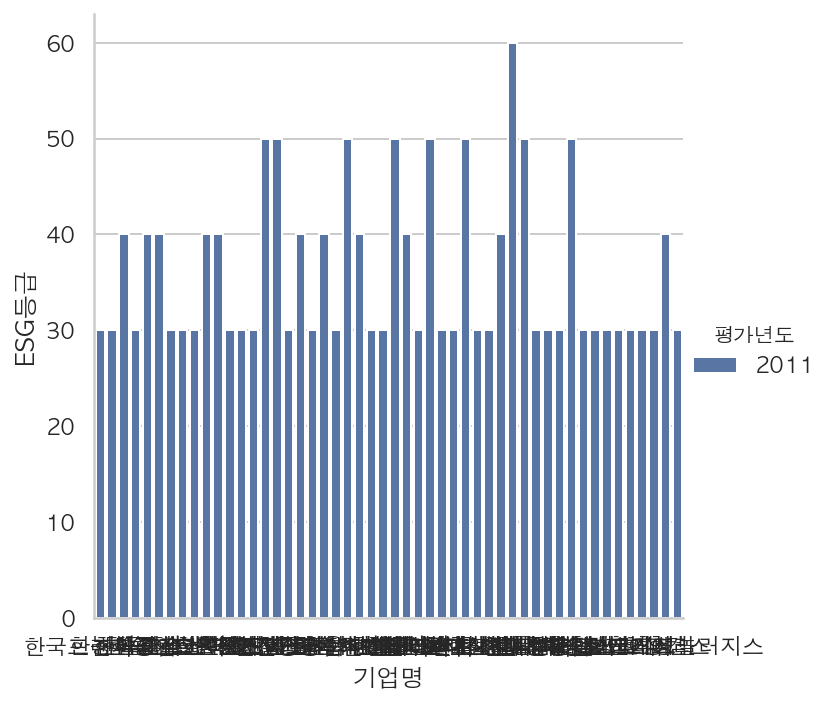

In [19]:
import seaborn as sns
plt.figure(figsize=(100,100))
sns.catplot(x="기업명", y="ESG등급",
                hue="평가년도",
                data=df_esg.tail(50), kind="bar")

In [20]:
mod = sys.modules[__name__]

for i in range(2011,2020):
    setattr(mod, 'df_esg_{}'.format(i),df_esg[df_esg["평가년도"]==i])

In [21]:
# kospi_balance = ["2015_사업보고서_01_재무상태표_20200515.txt","2016_사업보고서_01_재무상태표_20200626.txt","2017_사업보고서_01_재무상태표_20200626.txt",
#                 "2018_사업보고서_01_재무상태표_20200626.txt","2019_사업보고서_01_재무상태표_20200623.txt","2020_1분기보고서_01_재무상태표_20200620.txt"]

In [22]:
# def kospi_list(df):
#     df = df[df["시장구분"] == '유가증권시장상장법인'].rename(columns={"종목코드":'기업코드'})
#     df["기업코드"] = df["기업코드"].apply(lambda x: x.replace('[','')).apply(lambda x: x.replace(']',''))
#     df_list = list(pd.DataFrame(df.groupby("기업코드").size()).reset_index()["기업코드"])
#     return df_list

# # def kosdaq_list(df):
# #     df = df[df["시장구분"] == '코스닥시장상장법인'].rename(columns={"종목코드":'기업코드'})
# #     df["기업코드"] = df["기업코드"].apply(lambda x: x.replace('[','')).apply(lambda x: x.replace(']',''))
# #     df_list = list(pd.DataFrame(df.groupby("기업코드").size()).reset_index()["기업코드"])
# #     return df_list

In [23]:
# for i in range(2015,2021):
#     setattr(mod, 'kospi_{}'.format(i), kospi_list(pd.read_csv(kospi_balance[i-2015],sep = "\t",  engine='python', encoding = "cp949")[['종목코드','시장구분']]))

In [24]:
df_f = ["당기순이익.xlsx","자산총계.xlsx","매출액.xlsx","재고자산.xlsx","유보액_총자산.xlsx","비유동부채.xlsx","유동부채.xlsx","유동자산.xlsx"]

def change_columns(df):
    columns = ["종목코드","기업명","결산월","단위","2019","2018","2017","2016","2015","2014","2013","2012","2011","2010","2009","2008"]
    df.columns = columns
    df = df.rename(columns = {"종목코드":"기업코드"})
    return df
11
for i in range(1,9):
    setattr(mod, 'df_balance_{}'.format(i), change_columns(pd.read_excel(df_f[i-1])[9:]))
    

In [25]:
df_balance_1.head()

,기업코드,기업명,결산월,단위,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008
9,000020,동화약품,12,천원,9393855.0,10068113.0,47009013.0,26254318.0,5608652.0,4937205.0,1011860.0,1311241.0,17679223.0,11004144.0,9038512.0,28518530.0
10,000040,KR모터스,12,천원,-41041685.0,-24442080.0,-31501348.0,-9978618.0,-16596448.0,-12727830.0,-6614448.0,-8232051.0,1904749.0,-500478.0,-11215967.0,-9836186.0
11,000050,경방,12,천원,43621631.0,20189241.0,25315361.0,29474988.0,16692163.0,11488471.0,14574395.0,-7910168.0,-1131177.0,20060632.0,-241834.0,-14835529.0
12,000070,삼양홀딩스,12,천원,62043854.0,102512252.0,67186351.0,65137706.0,78016229.0,21003634.0,-26208014.0,129744740.0,168087785.0,143097497.0,97744707.0,-56122953.0
13,000080,하이트진로,12,천원,-42394951.0,22272353.0,12735966.0,38447239.0,53360072.0,21253791.0,79103048.0,103536195.0,70242546.0,47620381.0,123262285.0,154802712.0


<Figure size 3600x5040 with 0 Axes>

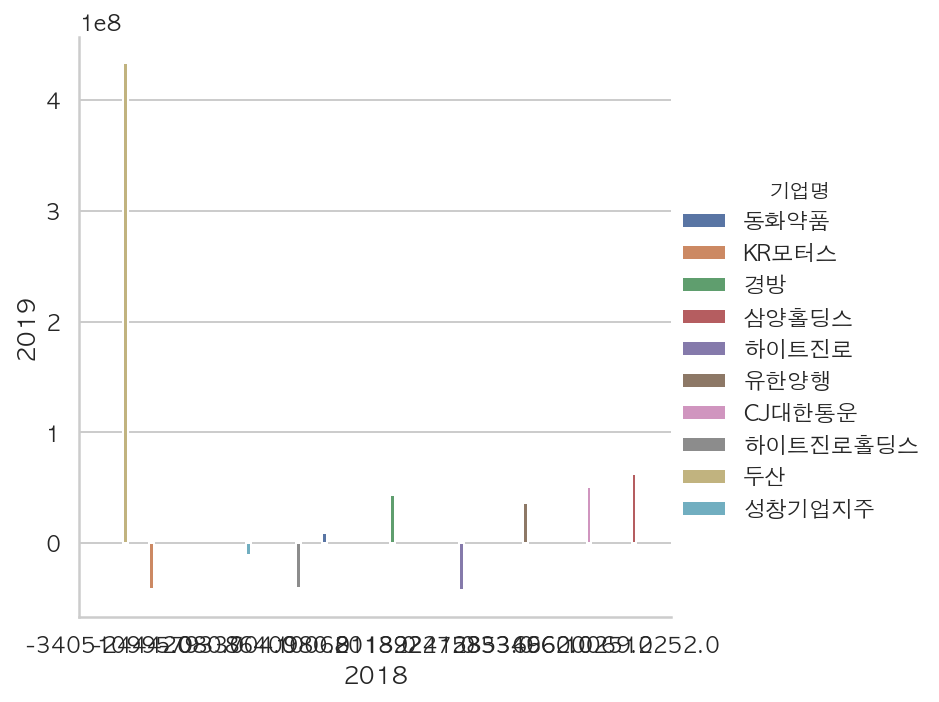

In [26]:
plt.figure(figsize=(50,70))
sns.catplot(x="2018", y="2019",
                hue="기업명",
                data=df_balance_1.head(10), kind="bar")

In [27]:
def merge_code(dfa,dfb):
    dfb = dfb[["기업코드","기업명"]][dfb["기업명"].isin(dfa["기업명"])]
    dfa = pd.merge(dfa,dfb, on="기업명",how="inner")
    return dfa

In [28]:
list_credit = [df_credit_2013,df_credit_2014,df_credit_2015,df_credit_2016,df_credit_2017,
             df_credit_2018,df_credit_2019]

list_esg = [df_esg_2011,df_esg_2012,df_esg_2013,df_esg_2014,df_esg_2015,df_esg_2016,
            df_esg_2017,df_esg_2018,df_esg_2019]

list_balance = [df_balance_1,df_balance_2,df_balance_3,df_balance_4,df_balance_5,
               df_balance_6,df_balance_7,df_balance_8,]

In [29]:
for i in range(2013,2020):
    setattr(mod, 'df_rating_{}'.format(i), merge_code(list_credit[i-2013],list_esg[i-2013]))

for k in range(2011, 2020):
    for i in range(1,9):
        setattr(mod, 'df_{}_{}'.format(k,i), pd.DataFrame(list_balance[i-1].iloc[:,[0,2023-k]]))

In [30]:
df_balance_1.head()

,기업코드,기업명,결산월,단위,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008
9,000020,동화약품,12,천원,9393855.0,10068113.0,47009013.0,26254318.0,5608652.0,4937205.0,1011860.0,1311241.0,17679223.0,11004144.0,9038512.0,28518530.0
10,000040,KR모터스,12,천원,-41041685.0,-24442080.0,-31501348.0,-9978618.0,-16596448.0,-12727830.0,-6614448.0,-8232051.0,1904749.0,-500478.0,-11215967.0,-9836186.0
11,000050,경방,12,천원,43621631.0,20189241.0,25315361.0,29474988.0,16692163.0,11488471.0,14574395.0,-7910168.0,-1131177.0,20060632.0,-241834.0,-14835529.0
12,000070,삼양홀딩스,12,천원,62043854.0,102512252.0,67186351.0,65137706.0,78016229.0,21003634.0,-26208014.0,129744740.0,168087785.0,143097497.0,97744707.0,-56122953.0
13,000080,하이트진로,12,천원,-42394951.0,22272353.0,12735966.0,38447239.0,53360072.0,21253791.0,79103048.0,103536195.0,70242546.0,47620381.0,123262285.0,154802712.0


In [31]:
df_columns = ["기업코드","당기순이익","자산총계","매출액","재고자산","유보액_총자산","비유동부채","유동부채","유동자산"]

In [32]:
data_frames_2011 = [df_2011_1,df_2011_2,df_2011_3,df_2011_4,df_2011_5,df_2011_6,df_2011_7,df_2011_8,]#df_2011_9,df_2011_10,df_2011_11,]
df_merged_2011 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_2011).dropna()
df_merged_2011.columns = df_columns

data_frames_2012 = [df_2012_1,df_2012_2,df_2012_3,df_2012_4,df_2012_5,df_2012_6,df_2012_7,df_2012_8,]#df_2012_9,df_2012_10,df_2012_11,]
df_merged_2012 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_2012).dropna()
df_merged_2012.columns = df_columns

data_frames_2013 = [df_2013_1,df_2013_2,df_2013_3,df_2013_4,df_2013_5,df_2013_6,df_2013_7,df_2013_8,]#df_2013_9,df_2013_10,df_2013_11,]
df_merged_2013 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_2013).dropna()
df_merged_2013.columns = df_columns

data_frames_2014 = [df_2014_1,df_2014_2,df_2014_3,df_2014_4,df_2014_5,df_2014_6,df_2014_7,df_2014_8,]#df_2014_9,df_2014_10,df_2014_11,]
df_merged_2014 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_2014).dropna()
df_merged_2014.columns = df_columns

data_frames_2015 = [df_2015_1,df_2015_2,df_2015_3,df_2015_4,df_2015_5,df_2015_6,df_2015_7,df_2015_8,]#df_2015_9,df_2015_10,df_2015_11,]
df_merged_2015 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_2015).dropna()
df_merged_2015.columns = df_columns

data_frames_2016 = [df_2016_1,df_2016_2,df_2016_3,df_2016_4,df_2016_5,df_2016_6,df_2016_7,df_2016_8,]#df_2016_9,df_2016_10,df_2016_11,]
df_merged_2016 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_2016).dropna()
df_merged_2016.columns = df_columns

data_frames_2017 = [df_2017_1,df_2017_2,df_2017_3,df_2017_4,df_2017_5,df_2017_6,df_2017_7,df_2017_8,]#df_2017_9,df_2017_10,df_2017_11,]
df_merged_2017 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_2017).dropna()
df_merged_2017.columns = df_columns

data_frames_2018 = [df_2018_1,df_2018_2,df_2018_3,df_2018_4,df_2018_5,df_2018_6,df_2018_7,df_2018_8,]#df_2018_9,df_2018_10,df_2018_11,]
df_merged_2018 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_2018).dropna()
df_merged_2018.columns = df_columns

data_frames_2019 = [df_2019_1,df_2019_2,df_2019_3,df_2019_4,df_2019_5,df_2019_6,df_2019_7,df_2019_8,]#df_2019_9,df_2019_10,df_2019_11,]
df_merged_2019 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_2019).dropna()
df_merged_2019.columns = df_columns

In [33]:
df_merged_2019.tail()

,기업코드,당기순이익,자산총계,매출액,재고자산,유보액_총자산,비유동부채,유동부채,유동자산
2126,900340,10227321.0,126212171.0,111593709.0,7172142.0,53.30,2593268.0,23470745.0,104820755.0
2128,950130,-20656016.0,69730399.0,43058688.0,8095298.0,39.46,24086655.0,17743727.0,25912635.0
2129,950140,2268541.0,115343361.0,133316920.0,29603554.0,48.01,15721100.0,38497196.0,70525502.0
2130,950160,-49270012.0,124536732.0,3053313.0,533368.0,75.13,16975346.0,13999851.0,112794308.0
2132,950180,31169202.0,320988517.0,102069412.0,648030.0,60.59,3164597.0,14232095.0,305367430.0


In [34]:
df_merged_2019.describe()

,당기순이익,자산총계,매출액,재고자산,유보액_총자산,비유동부채,유동부채,유동자산
count,1.954000e+03,1.954000e+03,1.954000e+03,1.954000e+03,1954.000000,1.954000e+03,1.954000e+03,1.954000e+03
mean,3.061505e+07,1.683793e+09,1.180229e+09,1.349468e+08,48.191024,3.673680e+08,4.376288e+08,5.994090e+08
std,5.219862e+08,1.223711e+10,7.426690e+09,8.655701e+08,23.335966,3.256970e+09,2.522146e+09,4.700556e+09
min,-2.872078e+09,3.556689e+06,3.581100e+04,4.000000e+02,0.420000,9.179000e+03,2.307210e+05,6.244020e+05
25%,-3.007749e+06,8.034788e+07,4.840280e+07,4.889068e+06,30.517500,3.830870e+06,1.788911e+07,3.902832e+07
50%,2.876534e+06,1.725496e+08,1.332599e+08,1.581332e+07,46.810000,1.344515e+07,4.759400e+07,8.325042e+07
75%,1.459635e+07,4.830802e+08,3.969356e+08,4.915218e+07,66.372500,4.939242e+07,1.468176e+08,2.201555e+08
max,2.173886e+10,3.525645e+11,2.304009e+11,2.676646e+10,130.190000,1.044765e+11,6.378276e+10,1.813853e+11


In [35]:
df_m = pd.read_excel("매출채권회전율.xlsx").rename(columns={"name":"기업명"})
df_m["매출채권회전율"] = df_m["매출채권회전율"].apply(lambda x : np.reciprocal(x))
for i in range(2011,2020):
        setattr(mod, 'df_m_{}'.format(i), df_m[df_m["DATE"]==i].replace("(주)","").dropna())
df_m_2011.head()

,Unnamed: 0,기업명,DATE,매출채권회전율
9,0,강남제비스코,2011,0.202332
18,0,강원랜드,2011,0.003415
45,0,경동나비엔,2011,0.091347
58,0,경동인베스트,2011,0.156648
67,0,경방,2011,0.091764


In [36]:
m_list = [df_m_2011, df_m_2012, df_m_2013, df_m_2014, df_m_2015, df_m_2016, df_m_2017, df_m_2018, df_m_2019,]

In [37]:
for i in range(2011,2020):
        setattr(mod, 'df_m_{}'.format(i), pd.merge(m_list[i-2011], df_balance_2, on="기업명", how="inner").drop_duplicates(['기업명'],keep="last").reset_index(drop=True).iloc[:,3:5] )

In [38]:
merged_list = [df_merged_2011,df_merged_2012,df_merged_2013,df_merged_2014,df_merged_2015,df_merged_2016,df_merged_2017,df_merged_2018,df_merged_2019]

In [39]:
m_list = [df_m_2011, df_m_2012, df_m_2013, df_m_2014, df_m_2015, df_m_2016, df_m_2017, df_m_2018, df_m_2019,]

In [40]:
for i in range(2011,2020):
        setattr(mod, 'df_merged_{}'.format(i), pd.merge(m_list[i-2011], merged_list[i-2011], on='기업코드', how='inner'))

In [41]:
list(df_merged_2011.columns)

['매출채권회전율',
 '기업코드',
 '당기순이익',
 '자산총계',
 '매출액',
 '재고자산',
 '유보액_총자산',
 '비유동부채',
 '유동부채',
 '유동자산']

In [42]:
df_merged_2011["부채총계"] = df_merged_2011["유동부채"] + df_merged_2011["비유동부채"]
df_merged_2011["운전자본"] = df_merged_2011["유동자산"] - df_merged_2011["유동부채"]
df_merged_2011["당기순이익_총자산"] = df_merged_2011["당기순이익"] / df_merged_2011["자산총계"]
df_merged_2011["부채총계_총자산"] = df_merged_2011["부채총계"] / df_merged_2011["자산총계"]
df_merged_2011["운전자본_총자산"] = df_merged_2011["운전자본"] / df_merged_2011["자산총계"]
df_merged_2011["유동자산_총자산"] = df_merged_2011["유동자산"] / df_merged_2011["자산총계"]
df_merged_2011["매출액_총자산"] = df_merged_2011["매출액"] / df_merged_2011["자산총계"]
df_merged_2011["재고자산_총자산"] = df_merged_2011["재고자산"] / df_merged_2011["자산총계"]
df_merged_2011["매출채권_총자산"] = (df_merged_2011["매출채권회전율"] * df_merged_2011["매출액"])/ df_merged_2011["자산총계"]

df_merged_2012["부채총계"] = df_merged_2012["유동부채"] + df_merged_2012["비유동부채"]
df_merged_2012["운전자본"] = df_merged_2012["유동자산"] - df_merged_2012["유동부채"]
df_merged_2012["당기순이익_총자산"] = df_merged_2012["당기순이익"] / df_merged_2012["자산총계"]
df_merged_2012["부채총계_총자산"] = df_merged_2012["부채총계"] / df_merged_2012["자산총계"]
df_merged_2012["운전자본_총자산"] = df_merged_2012["운전자본"] / df_merged_2012["자산총계"]
df_merged_2012["유동자산_총자산"] = df_merged_2012["유동자산"] / df_merged_2012["자산총계"]
df_merged_2012["매출액_총자산"] = df_merged_2012["매출액"] / df_merged_2012["자산총계"]
df_merged_2012["재고자산_총자산"] = df_merged_2012["재고자산"] / df_merged_2012["자산총계"]
df_merged_2012["매출채권_총자산"] = (df_merged_2012["매출채권회전율"] * df_merged_2012["매출액"])/ df_merged_2012["자산총계"]

df_merged_2013["부채총계"] = df_merged_2013["유동부채"] + df_merged_2013["비유동부채"]
df_merged_2013["운전자본"] = df_merged_2013["유동자산"] - df_merged_2013["유동부채"]
df_merged_2013["당기순이익_총자산"] = df_merged_2013["당기순이익"] / df_merged_2013["자산총계"]
df_merged_2013["부채총계_총자산"] = df_merged_2013["부채총계"] / df_merged_2013["자산총계"]
df_merged_2013["운전자본_총자산"] = df_merged_2013["운전자본"] / df_merged_2013["자산총계"]
df_merged_2013["유동자산_총자산"] = df_merged_2013["유동자산"] / df_merged_2013["자산총계"]
df_merged_2013["매출액_총자산"] = df_merged_2013["매출액"] / df_merged_2013["자산총계"]
df_merged_2013["재고자산_총자산"] = df_merged_2013["재고자산"] / df_merged_2013["자산총계"]
df_merged_2013["매출채권_총자산"] = (df_merged_2013["매출채권회전율"] * df_merged_2013["매출액"])/ df_merged_2013["자산총계"]

df_merged_2014["부채총계"] = df_merged_2014["유동부채"] + df_merged_2014["비유동부채"]
df_merged_2014["운전자본"] = df_merged_2014["유동자산"] - df_merged_2014["유동부채"]
df_merged_2014["당기순이익_총자산"] = df_merged_2014["당기순이익"] / df_merged_2014["자산총계"]
df_merged_2014["부채총계_총자산"] = df_merged_2014["부채총계"] / df_merged_2014["자산총계"]
df_merged_2014["운전자본_총자산"] = df_merged_2014["운전자본"] / df_merged_2014["자산총계"]
df_merged_2014["유동자산_총자산"] = df_merged_2014["유동자산"] / df_merged_2014["자산총계"]
df_merged_2014["매출액_총자산"] = df_merged_2014["매출액"] / df_merged_2014["자산총계"]
df_merged_2014["재고자산_총자산"] = df_merged_2014["재고자산"] / df_merged_2014["자산총계"]
df_merged_2014["매출채권_총자산"] = (df_merged_2014["매출채권회전율"] * df_merged_2014["매출액"])/ df_merged_2014["자산총계"]

df_merged_2015["부채총계"] = df_merged_2015["유동부채"] + df_merged_2015["비유동부채"]
df_merged_2015["운전자본"] = df_merged_2015["유동자산"] - df_merged_2015["유동부채"]
df_merged_2015["당기순이익_총자산"] = df_merged_2015["당기순이익"] / df_merged_2015["자산총계"]
df_merged_2015["부채총계_총자산"] = df_merged_2015["부채총계"] / df_merged_2015["자산총계"]
df_merged_2015["운전자본_총자산"] = df_merged_2015["운전자본"] / df_merged_2015["자산총계"]
df_merged_2015["유동자산_총자산"] = df_merged_2015["유동자산"] / df_merged_2015["자산총계"]
df_merged_2015["매출액_총자산"] = df_merged_2015["매출액"] / df_merged_2015["자산총계"]
df_merged_2015["재고자산_총자산"] = df_merged_2015["재고자산"] / df_merged_2015["자산총계"]
df_merged_2015["매출채권_총자산"] = (df_merged_2015["매출채권회전율"] * df_merged_2015["매출액"])/ df_merged_2015["자산총계"]

df_merged_2016["부채총계"] = df_merged_2016["유동부채"] + df_merged_2016["비유동부채"]
df_merged_2016["운전자본"] = df_merged_2016["유동자산"] - df_merged_2016["유동부채"]
df_merged_2016["당기순이익_총자산"] = df_merged_2016["당기순이익"] / df_merged_2016["자산총계"]
df_merged_2016["부채총계_총자산"] = df_merged_2016["부채총계"] / df_merged_2016["자산총계"]
df_merged_2016["운전자본_총자산"] = df_merged_2016["운전자본"] / df_merged_2016["자산총계"]
df_merged_2016["유동자산_총자산"] = df_merged_2016["유동자산"] / df_merged_2016["자산총계"]
df_merged_2016["매출액_총자산"] = df_merged_2016["매출액"] / df_merged_2016["자산총계"]
df_merged_2016["재고자산_총자산"] = df_merged_2016["재고자산"] / df_merged_2016["자산총계"]
df_merged_2016["매출채권_총자산"] = (df_merged_2016["매출채권회전율"] * df_merged_2016["매출액"])/ df_merged_2016["자산총계"]

df_merged_2017["부채총계"] = df_merged_2017["유동부채"] + df_merged_2017["비유동부채"]
df_merged_2017["운전자본"] = df_merged_2017["유동자산"] - df_merged_2017["유동부채"]
df_merged_2017["당기순이익_총자산"] = df_merged_2017["당기순이익"] / df_merged_2017["자산총계"]
df_merged_2017["부채총계_총자산"] = df_merged_2017["부채총계"] / df_merged_2017["자산총계"]
df_merged_2017["운전자본_총자산"] = df_merged_2017["운전자본"] / df_merged_2017["자산총계"]
df_merged_2017["유동자산_총자산"] = df_merged_2017["유동자산"] / df_merged_2017["자산총계"]
df_merged_2017["매출액_총자산"] = df_merged_2017["매출액"] / df_merged_2017["자산총계"]
df_merged_2017["재고자산_총자산"] = df_merged_2017["재고자산"] / df_merged_2017["자산총계"]
df_merged_2017["매출채권_총자산"] = (df_merged_2017["매출채권회전율"] * df_merged_2017["매출액"])/ df_merged_2017["자산총계"]

df_merged_2018["부채총계"] = df_merged_2018["유동부채"] + df_merged_2018["비유동부채"]
df_merged_2018["운전자본"] = df_merged_2018["유동자산"] - df_merged_2018["유동부채"]
df_merged_2018["당기순이익_총자산"] = df_merged_2018["당기순이익"] / df_merged_2018["자산총계"]
df_merged_2018["부채총계_총자산"] = df_merged_2018["부채총계"] / df_merged_2018["자산총계"]
df_merged_2018["운전자본_총자산"] = df_merged_2018["운전자본"] / df_merged_2018["자산총계"]
df_merged_2018["유동자산_총자산"] = df_merged_2018["유동자산"] / df_merged_2018["자산총계"]
df_merged_2018["매출액_총자산"] = df_merged_2018["매출액"] / df_merged_2018["자산총계"]
df_merged_2018["재고자산_총자산"] = df_merged_2018["재고자산"] / df_merged_2018["자산총계"]
df_merged_2018["매출채권_총자산"] = (df_merged_2018["매출채권회전율"] * df_merged_2018["매출액"])/ df_merged_2018["자산총계"]

df_merged_2019["부채총계"] = df_merged_2019["유동부채"] + df_merged_2019["비유동부채"]
df_merged_2019["운전자본"] = df_merged_2019["유동자산"] - df_merged_2019["유동부채"]
df_merged_2019["당기순이익_총자산"] = df_merged_2019["당기순이익"] / df_merged_2019["자산총계"]
df_merged_2019["부채총계_총자산"] = df_merged_2019["부채총계"] / df_merged_2019["자산총계"]
df_merged_2019["운전자본_총자산"] = df_merged_2019["운전자본"] / df_merged_2019["자산총계"]
df_merged_2019["유동자산_총자산"] = df_merged_2019["유동자산"] / df_merged_2019["자산총계"]
df_merged_2019["매출액_총자산"] = df_merged_2019["매출액"] / df_merged_2019["자산총계"]
df_merged_2019["재고자산_총자산"] = df_merged_2019["재고자산"] / df_merged_2019["자산총계"]
df_merged_2019["매출채권_총자산"] = (df_merged_2019["매출채권회전율"] * df_merged_2019["매출액"])/ df_merged_2019["자산총계"]

In [43]:
df_merged_2019.head()

,매출채권회전율,기업코드,당기순이익,자산총계,매출액,재고자산,유보액_총자산,비유동부채,유동부채,유동자산,부채총계,운전자본,당기순이익_총자산,부채총계_총자산,운전자본_총자산,유동자산_총자산,매출액_총자산,재고자산_총자산,매출채권_총자산
0,0.208766,000500,5462904.0,5.125735e+08,8.302644e+08,57086106.0,46.32,87775296.0,168070024.0,2.647750e+08,255845320.0,9.670498e+07,0.010658,0.499139,0.188666,0.516560,1.619796,0.111372,0.338158
1,0.201614,000860,17412514.0,6.722703e+08,3.325394e+08,50810941.0,77.37,51175758.0,59914686.0,1.787881e+08,111090444.0,1.188734e+08,0.025901,0.165247,0.176824,0.265947,0.494651,0.075581,0.099728
2,0.005801,035250,334653892.0,4.438119e+09,1.520080e+09,3636529.0,85.28,69017623.0,651342607.0,1.878191e+09,720360230.0,1.226849e+09,0.075404,0.162312,0.276434,0.423195,0.342506,0.000819,0.001987
3,0.110829,002100,4014664.0,3.708741e+08,2.275109e+08,133714688.0,48.22,46380814.0,122608005.0,1.850201e+08,168988819.0,6.241209e+07,0.010825,0.455650,0.168284,0.498876,0.613445,0.360539,0.067988
4,0.123546,009450,27852090.0,6.098083e+08,7.742907e+08,138114361.0,47.35,38512178.0,270253541.0,2.742792e+08,308765719.0,4.025616e+06,0.045674,0.506332,0.006601,0.449779,1.269728,0.226488,0.156869


In [44]:
data_frames_a_2011 = [df_merged_2011,df_esg_2011]
df_merged_b_2011 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_a_2011).dropna()

data_frames_a_2012 = [df_merged_2012,df_esg_2012]
df_merged_b_2012 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_a_2012).dropna()

data_frames_a_2013 = [df_merged_2013,df_esg_2013]
df_merged_b_2013 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_a_2013).dropna()

data_frames_a_2014 = [df_merged_2014,df_esg_2014]
df_merged_b_2014 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_a_2014).dropna()

data_frames_a_2015 = [df_merged_2015,df_esg_2015]
df_merged_b_2015 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_a_2015).dropna()

data_frames_a_2016 = [df_merged_2016,df_esg_2016]
df_merged_b_2016 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_a_2016).dropna()

data_frames_a_2017 = [df_merged_2017,df_esg_2017]
df_merged_b_2017 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_a_2017).dropna()

data_frames_a_2018 = [df_merged_2018,df_esg_2018]
df_merged_b_2018 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_a_2018).dropna()

data_frames_a_2019 = [df_merged_2019,df_esg_2019]
df_merged_b_2019 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_a_2019).dropna()

In [45]:
df_merged_b_2019.head()

,매출채권회전율,기업코드,당기순이익,자산총계,매출액,재고자산,유보액_총자산,비유동부채,유동부채,유동자산,부채총계,운전자본,당기순이익_총자산,부채총계_총자산,운전자본_총자산,유동자산_총자산,매출액_총자산,재고자산_총자산,매출채권_총자산,기업명,ESG등급,지배구조,사회,환경,평가년도
0,0.208766,000500,5462904.0,5.125735e+08,8.302644e+08,57086106.0,46.32,87775296.0,168070024.0,2.647750e+08,255845320.0,9.670498e+07,0.010658,0.499139,0.188666,0.516560,1.619796,0.111372,0.338158,가온전선,30.0,40.0,20.0,30.0,2019
1,0.201614,000860,17412514.0,6.722703e+08,3.325394e+08,50810941.0,77.37,51175758.0,59914686.0,1.787881e+08,111090444.0,1.188734e+08,0.025901,0.165247,0.176824,0.265947,0.494651,0.075581,0.099728,강남제비스코,20.0,30.0,20.0,20.0,2019
2,0.005801,035250,334653892.0,4.438119e+09,1.520080e+09,3636529.0,85.28,69017623.0,651342607.0,1.878191e+09,720360230.0,1.226849e+09,0.075404,0.162312,0.276434,0.423195,0.342506,0.000819,0.001987,강원랜드,40.0,30.0,50.0,40.0,2019
3,0.110829,002100,4014664.0,3.708741e+08,2.275109e+08,133714688.0,48.22,46380814.0,122608005.0,1.850201e+08,168988819.0,6.241209e+07,0.010825,0.455650,0.168284,0.498876,0.613445,0.360539,0.067988,경농,20.0,20.0,40.0,30.0,2019
4,0.123546,009450,27852090.0,6.098083e+08,7.742907e+08,138114361.0,47.35,38512178.0,270253541.0,2.742792e+08,308765719.0,4.025616e+06,0.045674,0.506332,0.006601,0.449779,1.269728,0.226488,0.156869,경동나비엔,40.0,30.0,50.0,30.0,2019


In [46]:
df_merged_b_2011 = df_merged_b_2011.iloc[:,[1,6,12,13,14,15,16,17,18,20,21,22,23]]#.rename(columns={"자산총계":"자산총계"})
df_merged_b_2012 = df_merged_b_2012.iloc[:,[1,6,12,13,14,15,16,17,18,20,21,22,23]]#.rename(columns={"자산총계":"자산총계"})
df_merged_b_2013 = df_merged_b_2013.iloc[:,[1,6,12,13,14,15,16,17,18,20,21,22,23]]#.rename(columns={"자산총계":"자산총계"})
df_merged_b_2014 = df_merged_b_2014.iloc[:,[1,6,12,13,14,15,16,17,18,20,21,22,23]]#.rename(columns={"자산총계":"자산총계"})
df_merged_b_2015 = df_merged_b_2015.iloc[:,[1,6,12,13,14,15,16,17,18,20,21,22,23]]#.rename(columns={"자산총계":"자산총계"})
df_merged_b_2016 = df_merged_b_2016.iloc[:,[1,6,12,13,14,15,16,17,18,20,21,22,23]]#.rename(columns={"자산총계":"자산총계"})
df_merged_b_2017 = df_merged_b_2017.iloc[:,[1,6,12,13,14,15,16,17,18,20,21,22,23]]#.rename(columns={"자산총계":"자산총계"})
df_merged_b_2018 = df_merged_b_2018.iloc[:,[1,6,12,13,14,15,16,17,18,20,21,22,23]]#.rename(columns={"자산총계":"자산총계"})
df_merged_b_2019 = df_merged_b_2019.iloc[:,[1,6,12,13,14,15,16,17,18,20,21,22,23]]#.rename(columns={"자산총계":"자산총계"})

In [47]:
df_merged_b_2011.head()

,기업코드,유보액_총자산,당기순이익_총자산,부채총계_총자산,운전자본_총자산,유동자산_총자산,매출액_총자산,재고자산_총자산,매출채권_총자산,ESG등급,지배구조,사회,환경
0,009450,58.86,0.035967,0.361294,0.181787,0.492049,1.296477,0.230949,0.118429,30.0,30.0,30.0,30.0
1,012610,45.08,0.009029,0.448546,0.202866,0.542521,0.624211,0.275912,0.149806,30.0,30.0,30.0,30.0
2,013580,26.90,0.007593,0.671022,0.311192,0.729252,1.116061,0.049018,0.000419,30.0,30.0,30.0,30.0
3,004200,2.13,-0.218116,0.885928,0.190290,0.825778,0.567454,0.212773,0.001521,40.0,30.0,40.0,30.0
4,010130,72.71,0.154950,0.237891,0.380408,0.529407,1.206295,0.191584,0.045784,30.0,40.0,30.0,30.0


In [48]:
df_merged_b_2011.describe()

,유보액_총자산,당기순이익_총자산,부채총계_총자산,운전자본_총자산,유동자산_총자산,매출액_총자산,재고자산_총자산,매출채권_총자산,ESG등급,지배구조,사회,환경
count,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000
mean,39.074330,0.028554,0.537615,0.072449,0.453591,0.995991,0.125072,0.163291,34.553571,32.366071,34.508929,34.642857
std,18.707274,0.091628,0.169017,0.164865,0.146920,0.501768,0.079263,0.086492,8.458646,9.714762,8.456160,8.515728
min,0.680000,-0.465349,0.144976,-0.429492,0.034690,0.041882,0.000003,0.000419,30.000000,20.000000,30.000000,30.000000
25%,24.872500,0.005893,0.415709,-0.026168,0.344670,0.653314,0.068436,0.106822,30.000000,30.000000,30.000000,30.000000
50%,37.535000,0.029489,0.556953,0.067891,0.456917,0.910583,0.109207,0.158123,30.000000,30.000000,30.000000,30.000000
75%,51.705000,0.057630,0.652994,0.169666,0.555430,1.205276,0.165581,0.205793,40.000000,40.000000,40.000000,40.000000
max,89.170000,0.849782,0.981982,0.680787,0.825778,3.547339,0.462335,0.537075,60.000000,60.000000,60.000000,60.000000


In [49]:
df_merged_z_2013 = df_merged_b_2013[df_merged_b_2013["기업코드"].isin(list(set(df_merged_b_2011["기업코드"])&set(df_merged_b_2013["기업코드"])&set(df_merged_b_2012["기업코드"])))].reset_index(drop=True)
df_merged_z_2012 = df_merged_b_2012[df_merged_b_2012["기업코드"].isin(list(set(df_merged_b_2011["기업코드"])&set(df_merged_b_2013["기업코드"])&set(df_merged_b_2012["기업코드"])))].reset_index(drop=True)
df_merged_z_2011 = df_merged_b_2011[df_merged_b_2011["기업코드"].isin(list(set(df_merged_b_2011["기업코드"])&set(df_merged_b_2013["기업코드"])&set(df_merged_b_2012["기업코드"])))].reset_index(drop=True)

In [50]:
print(len(df_merged_z_2011))
print(len(df_merged_z_2013))
print(len(df_merged_z_2012))

198
198
198


In [51]:
# df_merged_c_2013 = pd.DataFrame(columns=df_merged_b_2014.columns)
# df_merged_c_2013["기업코드"] = df_merged_z_2013["기업코드"]
# df_merged_c_2013['자산총계'] = ((df_merged_z_2013['자산총계'] + df_merged_z_2012['자산총계'])/2 -(df_merged_z_2012['자산총계'] + df_merged_z_2011['자산총계'])/2)\
#                                     / np.abs((df_merged_z_2012['자산총계'] + df_merged_z_2011['자산총계'])/2)
# df_merged_c_2013['유보액_총자산'] = ((df_merged_z_2013['유보액_총자산'] + df_merged_z_2012['유보액_총자산'])/2 -(df_merged_z_2012['유보액_총자산'] + df_merged_z_2011['유보액_총자산'])/2)\
#                                     / np.abs((df_merged_z_2012['유보액_총자산'] + df_merged_z_2011['유보액_총자산'])/2)
# df_merged_c_2013['당기순이익_총자산'] = ((df_merged_z_2013['당기순이익_총자산'] + df_merged_z_2012['당기순이익_총자산'])/2 -(df_merged_z_2012['당기순이익_총자산'] + df_merged_z_2011['당기순이익_총자산'])/2)\
#                                     / np.abs((df_merged_z_2012['당기순이익_총자산'] + df_merged_z_2011['당기순이익_총자산'])/2)
# df_merged_c_2013['부채총계_총자산'] = ((df_merged_z_2013['부채총계_총자산'] + df_merged_z_2012['부채총계_총자산'])/2 -(df_merged_z_2012['부채총계_총자산'] + df_merged_z_2012['부채총계_총자산'])/2)\
#                                     / np.abs((df_merged_z_2012['부채총계_총자산'] + df_merged_z_2011['부채총계_총자산'])/2)
# df_merged_c_2013['운전자본_총자산'] = ((df_merged_z_2013['운전자본_총자산'] + df_merged_z_2012['운전자본_총자산'])/2 -(df_merged_z_2012['운전자본_총자산'] + df_merged_z_2011['운전자본_총자산'])/2)\
#                                     / np.abs((df_merged_z_2012['운전자본_총자산'] + df_merged_z_2011['운전자본_총자산'])/2)
# df_merged_c_2013['매출액_총자산'] = ((df_merged_z_2013['매출액_총자산'] + df_merged_z_2012['매출액_총자산'])/2 -(df_merged_z_2012['매출액_총자산'] + df_merged_z_2011['매출액_총자산'])/2)\
#                                     / np.abs((df_merged_z_2012['매출액_총자산'] + df_merged_z_2011['매출액_총자산'])/2)
# df_merged_c_2013['재고자산_총자산'] = ((df_merged_z_2013['재고자산_총자산'] + df_merged_z_2012['재고자산_총자산'])/2 -(df_merged_z_2012['재고자산_총자산'] + df_merged_z_2011['재고자산_총자산'])/2)\
#                                     / np.abs((df_merged_z_2012['재고자산_총자산'] + df_merged_z_2011['재고자산_총자산'])/2)
# df_merged_c_2013['유동자산_총자산'] = ((df_merged_z_2013['유동자산_총자산'] + df_merged_z_2012['유동자산_총자산'])/2 -(df_merged_z_2012['유동자산_총자산'] + df_merged_z_2011['유동자산_총자산'])/2)\
#                                     / np.abs((df_merged_z_2012['유동자산_총자산'] + df_merged_z_2011['유동자산_총자산'])/2)
# df_merged_c_2013['매출채권_총자산'] = ((df_merged_z_2013['매출채권_총자산'] + df_merged_z_2012['매출채권_총자산'])/2 -(df_merged_z_2012['매출채권_총자산'] + df_merged_z_2011['매출채권_총자산'])/2)\
#                                     / np.abs((df_merged_z_2012['매출채권_총자산'] + df_merged_z_2011['매출채권_총자산'])/2)
# df_merged_c_2013['ESG등급'] = (df_merged_z_2013['ESG등급'] + df_merged_z_2012['ESG등급'])/2 -  (df_merged_z_2012['ESG등급'] + df_merged_z_2011['ESG등급'])/2
# df_merged_c_2013['지배구조'] = (df_merged_z_2013['지배구조'] + df_merged_z_2012['지배구조'])/2 - (df_merged_z_2012['지배구조'] + df_merged_z_2011['지배구조'])/2
# df_merged_c_2013['사회'] = (df_merged_z_2013['사회'] + df_merged_z_2012['사회'])/2 - (df_merged_z_2012['사회'] + df_merged_z_2011['사회'])/2
# df_merged_c_2013['환경'] = (df_merged_z_2013['환경'] + df_merged_z_2012['환경'])/2 - (df_merged_z_2012['환경'] +df_merged_z_2011['환경'])/2

In [52]:
# df_total_2014 = pd.merge(df_rating_2014,df_merged_c_2013.dropna(), on="기업코드", how="inner")

In [53]:
# df_total_2014.describe()

In [54]:
df_merged_z_2014 = df_merged_b_2014[df_merged_b_2014["기업코드"].isin(list(set(df_merged_b_2014["기업코드"])&set(df_merged_b_2013["기업코드"])&set(df_merged_b_2012["기업코드"])))].reset_index(drop=True)
df_merged_z_2013 = df_merged_b_2013[df_merged_b_2013["기업코드"].isin(list(set(df_merged_b_2014["기업코드"])&set(df_merged_b_2013["기업코드"])&set(df_merged_b_2012["기업코드"])))].reset_index(drop=True)
df_merged_z_2012 = df_merged_b_2012[df_merged_b_2012["기업코드"].isin(list(set(df_merged_b_2014["기업코드"])&set(df_merged_b_2013["기업코드"])&set(df_merged_b_2012["기업코드"])))].reset_index(drop=True)

In [55]:
print(len(df_merged_z_2014))
print(len(df_merged_z_2013))
print(len(df_merged_z_2012))

500
500
500


In [56]:
df_merged_b_2014.columns

Index(['기업코드', '유보액_총자산', '당기순이익_총자산', '부채총계_총자산', '운전자본_총자산',
       '유동자산_총자산', '매출액_총자산', '재고자산_총자산', '매출채권_총자산', 'ESG등급', '지배구조', '사회',
       '환경'],
      dtype='object')

In [57]:
df_merged_c_2014 = pd.DataFrame(columns=df_merged_b_2014.columns)
df_merged_c_2014["기업코드"] = df_merged_z_2014["기업코드"]
# df_merged_c_2014['자산총계'] = ((df_merged_z_2014['자산총계'] + df_merged_z_2013['자산총계'])/2 -(df_merged_z_2013['자산총계'] + df_merged_z_2012['자산총계'])/2)\
#                                     / np.abs((df_merged_z_2013['자산총계'] + df_merged_z_2012['자산총계'])/2)
df_merged_c_2014['유보액_총자산'] = ((df_merged_z_2014['유보액_총자산'] + df_merged_z_2013['유보액_총자산'])/2 -(df_merged_z_2013['유보액_총자산'] + df_merged_z_2012['유보액_총자산'])/2)\
                                    / np.abs((df_merged_z_2013['유보액_총자산'] + df_merged_z_2012['유보액_총자산'])/2)
df_merged_c_2014['당기순이익_총자산'] = ((df_merged_z_2014['당기순이익_총자산'] + df_merged_z_2013['당기순이익_총자산'])/2 -(df_merged_z_2013['당기순이익_총자산'] + df_merged_z_2012['당기순이익_총자산'])/2)\
                                    / np.abs((df_merged_z_2013['당기순이익_총자산'] + df_merged_z_2012['당기순이익_총자산'])/2)
df_merged_c_2014['부채총계_총자산'] = ((df_merged_z_2014['부채총계_총자산'] + df_merged_z_2013['부채총계_총자산'])/2 -(df_merged_z_2013['부채총계_총자산'] + df_merged_z_2012['부채총계_총자산'])/2)\
                                    / np.abs((df_merged_z_2013['부채총계_총자산'] + df_merged_z_2012['부채총계_총자산'])/2)
df_merged_c_2014['운전자본_총자산'] = ((df_merged_z_2014['운전자본_총자산'] + df_merged_z_2013['운전자본_총자산'])/2 -(df_merged_z_2013['운전자본_총자산'] + df_merged_z_2012['운전자본_총자산'])/2)\
                                    / np.abs((df_merged_z_2013['운전자본_총자산'] + df_merged_z_2012['운전자본_총자산'])/2)
df_merged_c_2014['매출액_총자산'] = ((df_merged_z_2014['매출액_총자산'] + df_merged_z_2013['매출액_총자산'])/2 -(df_merged_z_2013['매출액_총자산'] + df_merged_z_2012['매출액_총자산'])/2)\
                                    / np.abs((df_merged_z_2013['매출액_총자산'] + df_merged_z_2012['매출액_총자산'])/2)
df_merged_c_2014['재고자산_총자산'] = ((df_merged_z_2014['재고자산_총자산'] + df_merged_z_2013['재고자산_총자산'])/2 -(df_merged_z_2013['재고자산_총자산'] + df_merged_z_2012['재고자산_총자산'])/2)\
                                    / np.abs((df_merged_z_2013['재고자산_총자산'] + df_merged_z_2012['재고자산_총자산'])/2)
df_merged_c_2014['유동자산_총자산'] = ((df_merged_z_2014['유동자산_총자산'] + df_merged_z_2013['유동자산_총자산'])/2 -(df_merged_z_2013['유동자산_총자산'] + df_merged_z_2012['유동자산_총자산'])/2)\
                                    / np.abs((df_merged_z_2013['유동자산_총자산'] + df_merged_z_2012['유동자산_총자산'])/2)
df_merged_c_2014['매출채권_총자산'] = ((df_merged_z_2014['매출채권_총자산'] + df_merged_z_2013['매출채권_총자산'])/2 -(df_merged_z_2013['매출채권_총자산'] + df_merged_z_2012['매출채권_총자산'])/2)\
                                    / np.abs((df_merged_z_2013['매출채권_총자산'] + df_merged_z_2012['매출채권_총자산'])/2)
df_merged_c_2014['ESG등급'] = (df_merged_z_2014['ESG등급'] + df_merged_z_2013['ESG등급'])/2 -  (df_merged_z_2013['ESG등급'] + df_merged_z_2012['ESG등급'])/2
df_merged_c_2014['지배구조'] = (df_merged_z_2014['지배구조'] + df_merged_z_2013['지배구조'])/2 - (df_merged_z_2013['지배구조'] + df_merged_z_2012['지배구조'])/2
df_merged_c_2014['사회'] = (df_merged_z_2014['사회'] + df_merged_z_2013['사회'])/2 - (df_merged_z_2013['사회'] + df_merged_z_2012['사회'])/2
df_merged_c_2014['환경'] = (df_merged_z_2014['환경'] + df_merged_z_2013['환경'])/2 - (df_merged_z_2013['환경'] +df_merged_z_2012['환경'])/2

In [58]:
df_total_2015 = pd.merge(df_rating_2015,df_merged_c_2014.dropna(), on="기업코드", how="inner")

In [59]:
df_total_2015.describe()

,Point,공시일자,평가등급,유보액_총자산,당기순이익_총자산,부채총계_총자산,운전자본_총자산,유동자산_총자산,매출액_총자산,재고자산_총자산,매출채권_총자산,ESG등급,지배구조,사회,환경
count,88.000000,88.0,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000
mean,0.238636,2015.0,20.215909,-0.002035,-0.050477,-0.003175,-0.307540,-0.008522,-0.015935,0.037896,-0.029741,0.113636,-0.113636,0.170455,-0.056818
std,0.428693,0.0,2.918230,0.165001,3.360716,0.075280,2.120283,0.121064,0.100509,0.195032,0.130734,2.623641,3.633914,3.591886,3.260202
min,0.000000,2015.0,13.000000,-0.895540,-18.768662,-0.136945,-17.292365,-0.891102,-0.491995,-0.344980,-0.422015,-5.000000,-15.000000,-5.000000,-10.000000
25%,0.000000,2015.0,19.000000,-0.041370,-0.359184,-0.043466,-0.236534,-0.046792,-0.071423,-0.070979,-0.093689,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2015.0,20.000000,0.014038,-0.124938,-0.009728,-0.001761,-0.004081,-0.022451,0.019625,-0.043328,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2015.0,22.000000,0.049002,0.155066,0.013775,0.175545,0.036311,0.032021,0.091060,0.038905,0.000000,0.000000,0.000000,0.000000
max,1.000000,2015.0,26.000000,0.610924,15.662600,0.328808,2.405470,0.227128,0.306940,1.108948,0.395809,10.000000,10.000000,10.000000,10.000000


In [60]:
# df_kospi_2015 = df_total_2015[df_total_2015["기업코드"].isin(kospi_2015)]

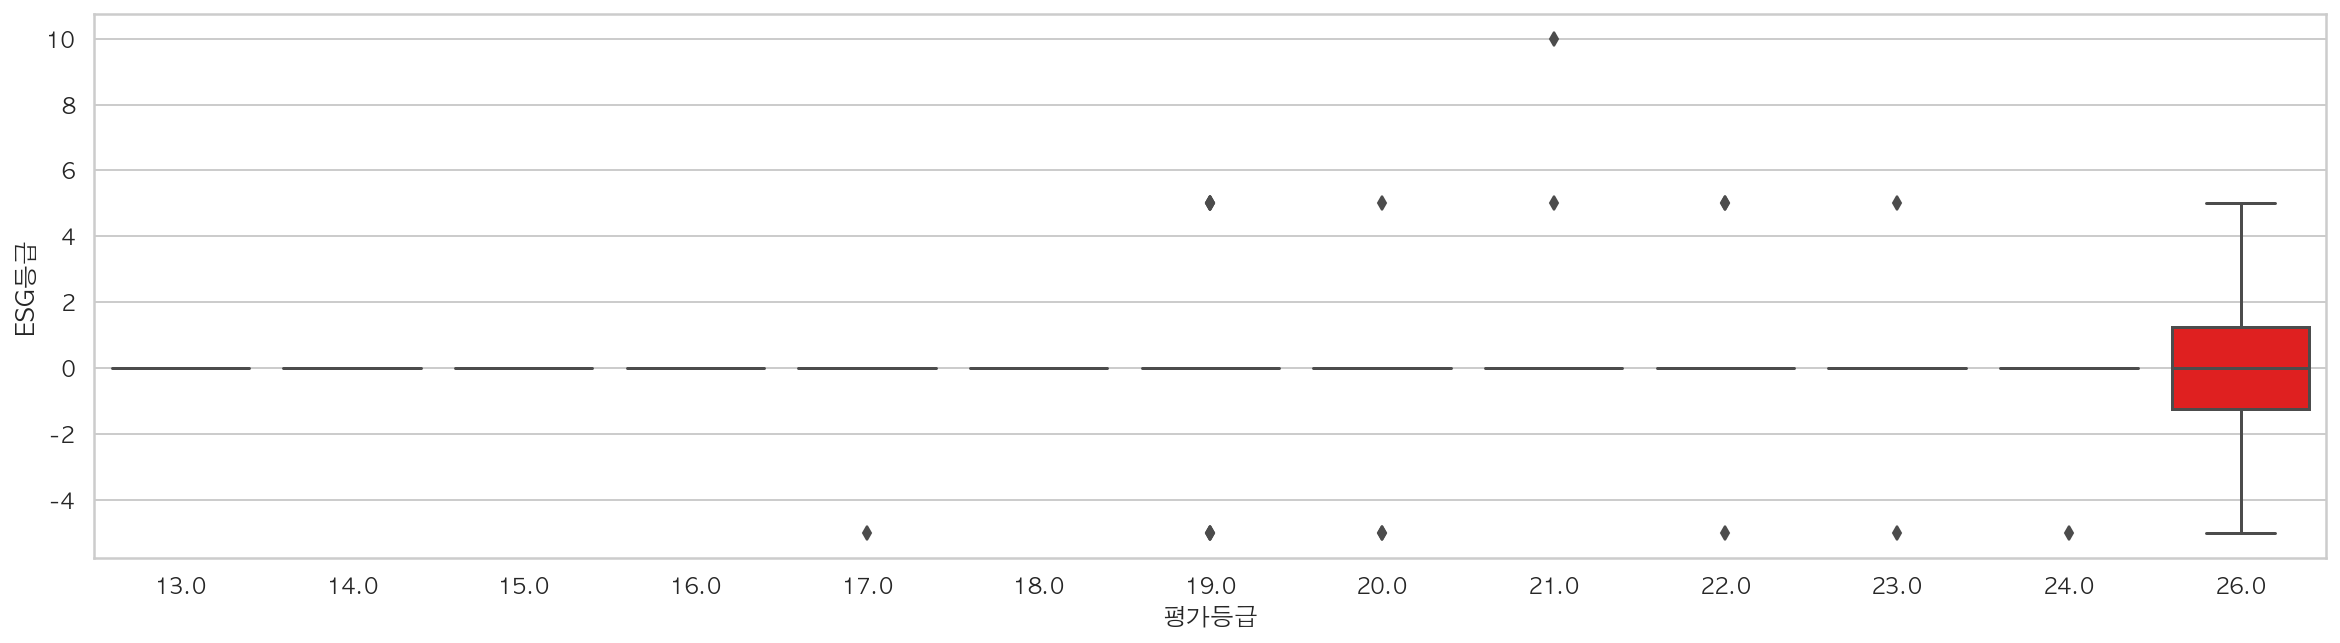

In [61]:
import seaborn as sns
plt.figure(figsize=(20,5))
sns.boxplot(
    data=df_total_2015,
    x='평가등급',
    y='ESG등급',
    color='red')

In [62]:
df_merged_z_2015 = df_merged_b_2014[df_merged_b_2015["기업코드"].isin(list(set(df_merged_b_2014["기업코드"])&set(df_merged_b_2013["기업코드"])&set(df_merged_b_2015["기업코드"])))].reset_index(drop=True)
df_merged_z_2014 = df_merged_b_2013[df_merged_b_2014["기업코드"].isin(list(set(df_merged_b_2014["기업코드"])&set(df_merged_b_2013["기업코드"])&set(df_merged_b_2015["기업코드"])))].reset_index(drop=True)
df_merged_z_2013 = df_merged_b_2012[df_merged_b_2013["기업코드"].isin(list(set(df_merged_b_2014["기업코드"])&set(df_merged_b_2013["기업코드"])&set(df_merged_b_2015["기업코드"])))].reset_index(drop=True)

In [63]:
df_merged_c_2015 = pd.DataFrame(columns=df_merged_b_2014.columns)
df_merged_c_2015["기업코드"] = df_merged_z_2015["기업코드"]
# df_merged_c_2015['자산총계'] = ((df_merged_z_2015['자산총계'] + df_merged_z_2014['자산총계'])/2 -(df_merged_z_2014['자산총계'] + df_merged_z_2013['자산총계'])/2)\
#                                     / np.abs((df_merged_z_2014['자산총계'] + df_merged_z_2013['자산총계'])/2)
df_merged_c_2015['유보액_총자산'] = ((df_merged_z_2015['유보액_총자산'] + df_merged_z_2014['유보액_총자산'])/2 -(df_merged_z_2014['유보액_총자산'] + df_merged_z_2013['유보액_총자산'])/2)\
                                    / np.abs((df_merged_z_2014['유보액_총자산'] + df_merged_z_2013['유보액_총자산'])/2)
df_merged_c_2015['당기순이익_총자산'] = ((df_merged_z_2015['당기순이익_총자산'] + df_merged_z_2014['당기순이익_총자산'])/2 -(df_merged_z_2014['당기순이익_총자산'] + df_merged_z_2013['당기순이익_총자산'])/2)\
                                    / np.abs((df_merged_z_2014['당기순이익_총자산'] + df_merged_z_2013['당기순이익_총자산'])/2)
df_merged_c_2015['부채총계_총자산'] = ((df_merged_z_2015['부채총계_총자산'] + df_merged_z_2014['부채총계_총자산'])/2 -(df_merged_z_2014['부채총계_총자산'] + df_merged_z_2013['부채총계_총자산'])/2)\
                                    / np.abs((df_merged_z_2014['부채총계_총자산'] + df_merged_z_2013['부채총계_총자산'])/2)
df_merged_c_2015['운전자본_총자산'] = ((df_merged_z_2014['운전자본_총자산'] + df_merged_z_2013['운전자본_총자산'])/2 -(df_merged_z_2014['운전자본_총자산'] + df_merged_z_2013['운전자본_총자산'])/2)\
                                    / np.abs((df_merged_z_2014['운전자본_총자산'] + df_merged_z_2013['운전자본_총자산'])/2)
df_merged_c_2015['매출액_총자산'] = ((df_merged_z_2015['매출액_총자산'] + df_merged_z_2014['매출액_총자산'])/2 -(df_merged_z_2014['매출액_총자산'] + df_merged_z_2013['매출액_총자산'])/2)\
                                    / np.abs((df_merged_z_2014['매출액_총자산'] + df_merged_z_2013['매출액_총자산'])/2)
df_merged_c_2015['재고자산_총자산'] = ((df_merged_z_2015['재고자산_총자산'] + df_merged_z_2014['재고자산_총자산'])/2 -(df_merged_z_2014['재고자산_총자산'] + df_merged_z_2013['재고자산_총자산'])/2)\
                                    / np.abs((df_merged_z_2014['재고자산_총자산'] + df_merged_z_2013['재고자산_총자산'])/2)
df_merged_c_2015['유동자산_총자산'] = ((df_merged_z_2015['유동자산_총자산'] + df_merged_z_2014['유동자산_총자산'])/2 -(df_merged_z_2014['유동자산_총자산'] + df_merged_z_2013['유동자산_총자산'])/2)\
                                    / np.abs((df_merged_z_2014['유동자산_총자산'] + df_merged_z_2013['유동자산_총자산'])/2)
df_merged_c_2015['매출채권_총자산'] = ((df_merged_z_2015['매출채권_총자산'] + df_merged_z_2014['매출채권_총자산'])/2 -(df_merged_z_2014['매출채권_총자산'] + df_merged_z_2013['매출채권_총자산'])/2)\
                                    / np.abs((df_merged_z_2014['매출채권_총자산'] + df_merged_z_2013['매출채권_총자산'])/2)
df_merged_c_2015['ESG등급'] = (df_merged_z_2015['ESG등급'] + df_merged_z_2014['ESG등급'])/2 -  (df_merged_z_2014['ESG등급'] + df_merged_z_2013['ESG등급'])/2
df_merged_c_2015['지배구조'] = (df_merged_z_2015['지배구조'] + df_merged_z_2014['지배구조'])/2 - (df_merged_z_2014['지배구조'] + df_merged_z_2013['지배구조'])/2
df_merged_c_2015['사회'] = (df_merged_z_2015['사회'] + df_merged_z_2014['사회'])/2 - (df_merged_z_2014['사회'] + df_merged_z_2013['사회'])/2
df_merged_c_2015['환경'] = (df_merged_z_2015['환경'] + df_merged_z_2014['환경'])/2 - (df_merged_z_2014['환경'] +df_merged_z_2013['환경'])/2

In [64]:
df_total_2016 = pd.merge(df_rating_2016,df_merged_c_2015.dropna(), on="기업코드", how="inner")

In [65]:
df_total_2016.describe()

,Point,공시일자,평가등급,유보액_총자산,당기순이익_총자산,부채총계_총자산,운전자본_총자산,유동자산_총자산,매출액_총자산,재고자산_총자산,매출채권_총자산,ESG등급,지배구조,사회,환경
count,76.000000,76.0,76.000000,76.000000,76.000000,76.000000,76.0,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000
mean,0.184211,2016.0,20.131579,0.018663,-1.958331,0.095069,0.0,-0.001302,0.004990,0.141646,-0.039099,1.644737,1.381579,1.776316,2.236842
std,0.390232,0.0,3.025854,0.378311,33.260433,0.357187,0.0,0.256223,0.318986,0.985851,0.543897,4.273028,6.613052,4.946645,4.350842
min,0.000000,2016.0,12.000000,-0.751254,-272.222801,-0.543661,0.0,-0.505444,-0.740069,-0.984222,-0.891513,-10.000000,-15.000000,-15.000000,-10.000000
25%,0.000000,2016.0,19.000000,-0.225756,-0.582046,-0.143019,0.0,-0.165884,-0.169535,-0.261351,-0.363255,0.000000,-5.000000,0.000000,0.000000
50%,0.000000,2016.0,20.000000,0.013845,-0.078737,0.001470,0.0,0.005948,0.030838,-0.031352,-0.062595,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2016.0,22.000000,0.210933,0.870256,0.255506,0.0,0.165626,0.174851,0.278826,0.104992,5.000000,5.000000,5.000000,5.000000
max,1.000000,2016.0,26.000000,1.200147,84.973778,1.396607,0.0,0.599984,1.154205,5.482586,3.106850,10.000000,15.000000,15.000000,15.000000


In [66]:
# df_kospi_2016 = df_total_2016[df_total_2016["기업코드"].isin(kospi_2016)]

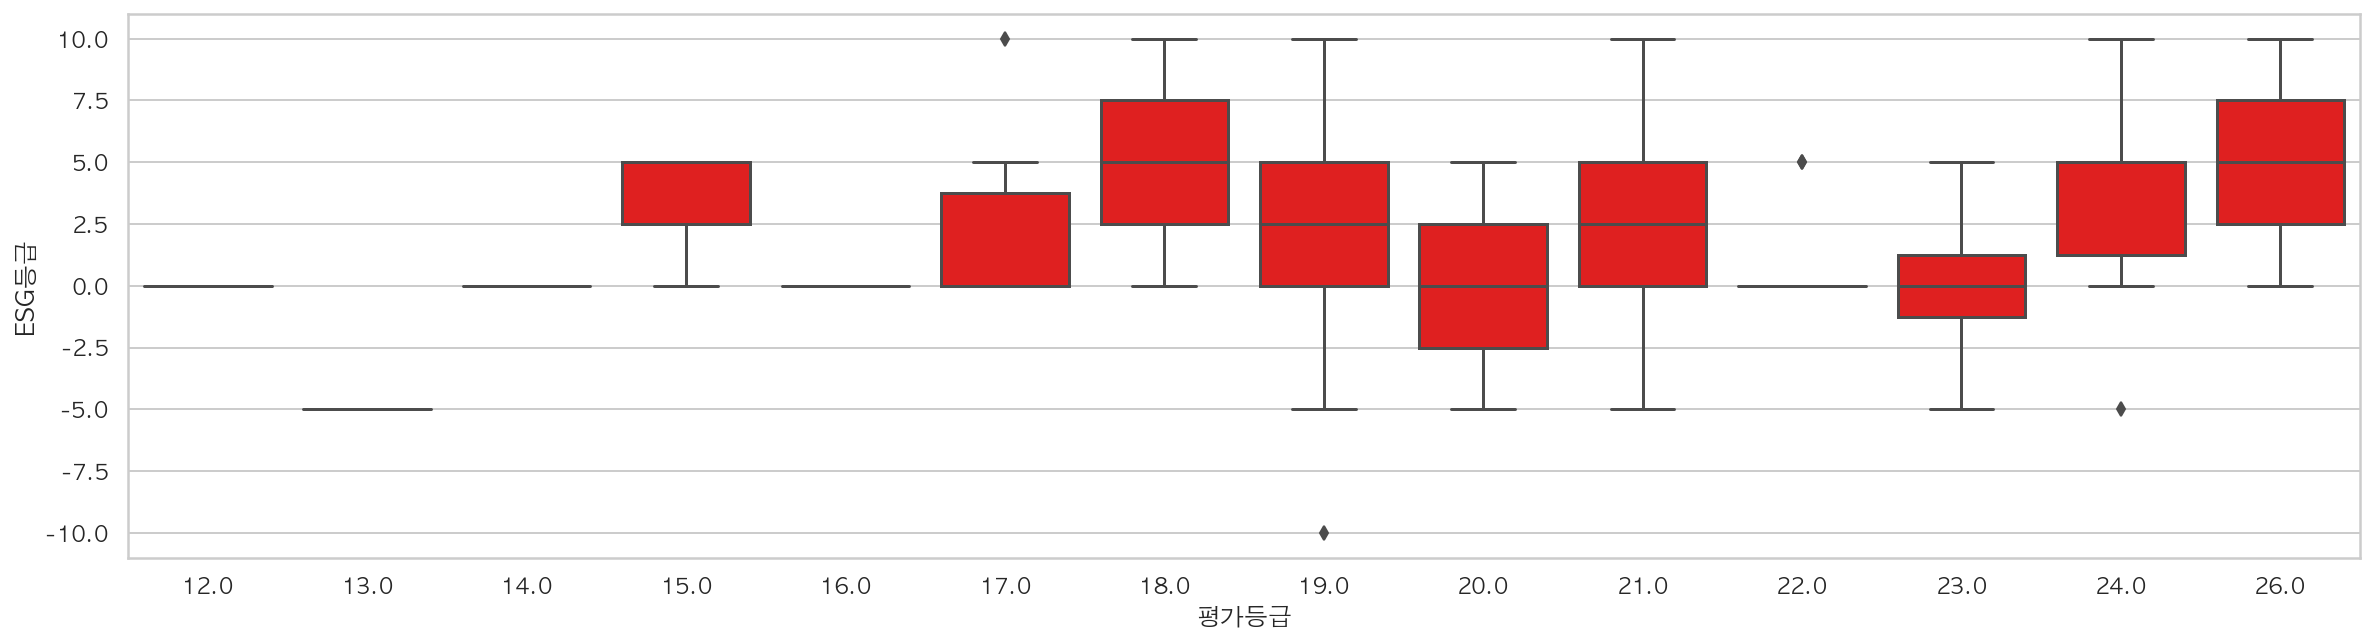

In [67]:
import seaborn as sns
plt.figure(figsize=(20,5))
sns.boxplot(
    data=df_total_2016,
    x='평가등급',
    y='ESG등급',
    color='red')

In [68]:
df_merged_z_2016 = df_merged_b_2016[df_merged_b_2016["기업코드"].isin(list(set(df_merged_b_2014["기업코드"])&set(df_merged_b_2016["기업코드"])&set(df_merged_b_2015["기업코드"])))].reset_index(drop=True)
df_merged_z_2015 = df_merged_b_2015[df_merged_b_2015["기업코드"].isin(list(set(df_merged_b_2014["기업코드"])&set(df_merged_b_2016["기업코드"])&set(df_merged_b_2015["기업코드"])))].reset_index(drop=True)
df_merged_z_2014 = df_merged_b_2014[df_merged_b_2014["기업코드"].isin(list(set(df_merged_b_2014["기업코드"])&set(df_merged_b_2016["기업코드"])&set(df_merged_b_2015["기업코드"])))].reset_index(drop=True)

In [69]:
df_merged_c_2016 = pd.DataFrame(columns=df_merged_b_2014.columns)
df_merged_c_2016["기업코드"] = df_merged_z_2016["기업코드"]
# df_merged_c_2016['자산총계'] = ((df_merged_z_2016['자산총계'] + df_merged_z_2015['자산총계'])/2 -(df_merged_z_2015['자산총계'] + df_merged_z_2014['자산총계'])/2)\
#                                     / np.abs((df_merged_z_2015['자산총계'] + df_merged_z_2014['자산총계'])/2)
df_merged_c_2016['유보액_총자산'] = ((df_merged_z_2016['유보액_총자산'] + df_merged_z_2015['유보액_총자산'])/2 -(df_merged_z_2015['유보액_총자산'] + df_merged_z_2014['유보액_총자산'])/2)\
                                    / np.abs((df_merged_z_2015['유보액_총자산'] + df_merged_z_2014['유보액_총자산'])/2)
df_merged_c_2016['당기순이익_총자산'] = ((df_merged_z_2016['당기순이익_총자산'] + df_merged_z_2015['당기순이익_총자산'])/2 -(df_merged_z_2015['당기순이익_총자산'] + df_merged_z_2014['당기순이익_총자산'])/2)\
                                    / np.abs((df_merged_z_2015['당기순이익_총자산'] + df_merged_z_2014['당기순이익_총자산'])/2)
df_merged_c_2016['부채총계_총자산'] = ((df_merged_z_2016['부채총계_총자산'] + df_merged_z_2015['부채총계_총자산'])/2 -(df_merged_z_2015['부채총계_총자산'] + df_merged_z_2014['부채총계_총자산'])/2)\
                                    / np.abs((df_merged_z_2015['부채총계_총자산'] + df_merged_z_2014['부채총계_총자산'])/2)
df_merged_c_2016['운전자본_총자산'] = ((df_merged_z_2016['운전자본_총자산'] + df_merged_z_2015['운전자본_총자산'])/2 -(df_merged_z_2015['운전자본_총자산'] + df_merged_z_2014['운전자본_총자산'])/2)\
                                    / np.abs((df_merged_z_2015['운전자본_총자산'] + df_merged_z_2014['운전자본_총자산'])/2)
df_merged_c_2016['매출액_총자산'] = ((df_merged_z_2016['매출액_총자산'] + df_merged_z_2015['매출액_총자산'])/2 -(df_merged_z_2015['매출액_총자산'] + df_merged_z_2014['매출액_총자산'])/2)\
                                    / np.abs((df_merged_z_2015['매출액_총자산'] + df_merged_z_2014['매출액_총자산'])/2)
df_merged_c_2016['재고자산_총자산'] = ((df_merged_z_2016['재고자산_총자산'] + df_merged_z_2015['재고자산_총자산'])/2 -(df_merged_z_2015['재고자산_총자산'] + df_merged_z_2014['재고자산_총자산'])/2)\
                                    / np.abs((df_merged_z_2015['재고자산_총자산'] + df_merged_z_2014['재고자산_총자산'])/2)
df_merged_c_2016['유동자산_총자산'] = ((df_merged_z_2016['유동자산_총자산'] + df_merged_z_2015['유동자산_총자산'])/2 -(df_merged_z_2015['유동자산_총자산'] + df_merged_z_2014['유동자산_총자산'])/2)\
                                    / np.abs((df_merged_z_2015['유동자산_총자산'] + df_merged_z_2014['유동자산_총자산'])/2)
df_merged_c_2016['매출채권_총자산'] = ((df_merged_z_2016['매출채권_총자산'] + df_merged_z_2015['매출채권_총자산'])/2 -(df_merged_z_2015['매출채권_총자산'] + df_merged_z_2014['매출채권_총자산'])/2)\
                                    / np.abs((df_merged_z_2015['매출채권_총자산'] + df_merged_z_2014['매출채권_총자산'])/2)
df_merged_c_2016['ESG등급'] = (df_merged_z_2016['ESG등급'] + df_merged_z_2015['ESG등급'])/2 -  (df_merged_z_2015['ESG등급'] + df_merged_z_2014['ESG등급'])/2
df_merged_c_2016['지배구조'] = (df_merged_z_2016['지배구조'] + df_merged_z_2015['지배구조'])/2 - (df_merged_z_2015['지배구조'] + df_merged_z_2014['지배구조'])/2
df_merged_c_2016['사회'] = (df_merged_z_2016['사회'] + df_merged_z_2015['사회'])/2 - (df_merged_z_2015['사회'] + df_merged_z_2014['사회'])/2
df_merged_c_2016['환경'] = (df_merged_z_2016['환경'] + df_merged_z_2015['환경'])/2 - (df_merged_z_2015['환경'] +df_merged_z_2014['환경'])/2

In [70]:
df_total_2017 = pd.merge(df_rating_2017,df_merged_c_2016.dropna(), on="기업코드", how="inner")

In [71]:
df_total_2017.describe()

,Point,공시일자,평가등급,유보액_총자산,당기순이익_총자산,부채총계_총자산,운전자본_총자산,유동자산_총자산,매출액_총자산,재고자산_총자산,매출채권_총자산,ESG등급,지배구조,사회,환경
count,85.000000,85.0,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000
mean,0.176471,2017.0,20.458824,-0.010809,-0.239472,0.002696,-0.340466,0.001574,-0.038989,0.000514,0.016093,-0.117647,-2.352941,1.294118,0.705882
std,0.383482,0.0,2.834956,0.174802,4.641228,0.059531,2.180148,0.085821,0.083895,0.383019,0.404635,2.779225,5.377878,4.638923,3.287145
min,0.000000,2017.0,10.000000,-0.678625,-32.677060,-0.122801,-18.664613,-0.207401,-0.278875,-0.504089,-0.577981,-10.000000,-15.000000,-10.000000,-5.000000
25%,0.000000,2017.0,19.000000,-0.057978,-0.271168,-0.033101,-0.256108,-0.047305,-0.088456,-0.097648,-0.068712,0.000000,-5.000000,0.000000,0.000000
50%,0.000000,2017.0,21.000000,-0.006795,-0.043840,-0.001149,-0.035356,-0.004681,-0.043831,-0.038442,-0.019579,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2017.0,22.000000,0.047841,0.332431,0.035118,0.133875,0.048310,0.000159,0.023215,0.034849,0.000000,0.000000,5.000000,0.000000
max,1.000000,2017.0,26.000000,1.126149,19.651796,0.226610,3.813707,0.296906,0.300569,2.740919,3.520638,5.000000,10.000000,15.000000,10.000000


In [72]:
# df_kospi_2017 = df_total_2017[df_total_2017["기업코드"].isin(kospi_2017)]

In [73]:
df_merged_z_2017 = df_merged_b_2017[df_merged_b_2017["기업코드"].isin(list(set(df_merged_b_2017["기업코드"])&set(df_merged_b_2016["기업코드"])&set(df_merged_b_2015["기업코드"])))].reset_index(drop=True)
df_merged_z_2016 = df_merged_b_2016[df_merged_b_2016["기업코드"].isin(list(set(df_merged_b_2017["기업코드"])&set(df_merged_b_2016["기업코드"])&set(df_merged_b_2015["기업코드"])))].reset_index(drop=True)
df_merged_z_2015 = df_merged_b_2015[df_merged_b_2015["기업코드"].isin(list(set(df_merged_b_2017["기업코드"])&set(df_merged_b_2016["기업코드"])&set(df_merged_b_2015["기업코드"])))].reset_index(drop=True)

In [74]:
df_merged_c_2017 = pd.DataFrame(columns=df_merged_b_2014.columns)
df_merged_c_2017["기업코드"] = df_merged_z_2017["기업코드"]
# df_merged_c_2017['자산총계'] = ((df_merged_z_2017['자산총계'] + df_merged_z_2016['자산총계'])/2 -(df_merged_z_2016['자산총계'] + df_merged_z_2015['자산총계'])/2)\
#                                     / np.abs((df_merged_z_2016['자산총계'] + df_merged_z_2015['자산총계'])/2)
df_merged_c_2017['유보액_총자산'] = ((df_merged_z_2017['유보액_총자산'] + df_merged_z_2016['유보액_총자산'])/2 -(df_merged_z_2016['유보액_총자산'] + df_merged_z_2015['유보액_총자산'])/2)\
                                    / np.abs((df_merged_z_2016['유보액_총자산'] + df_merged_z_2015['유보액_총자산'])/2)
df_merged_c_2017['당기순이익_총자산'] = ((df_merged_z_2017['당기순이익_총자산'] + df_merged_z_2016['당기순이익_총자산'])/2 -(df_merged_z_2016['당기순이익_총자산'] + df_merged_z_2015['당기순이익_총자산'])/2)\
                                    / np.abs((df_merged_z_2016['당기순이익_총자산'] + df_merged_z_2015['당기순이익_총자산'])/2)
df_merged_c_2017['부채총계_총자산'] = ((df_merged_z_2017['부채총계_총자산'] + df_merged_z_2016['부채총계_총자산'])/2 -(df_merged_z_2016['부채총계_총자산'] + df_merged_z_2015['부채총계_총자산'])/2)\
                                    / np.abs((df_merged_z_2016['부채총계_총자산'] + df_merged_z_2015['부채총계_총자산'])/2)
df_merged_c_2017['운전자본_총자산'] = ((df_merged_z_2017['운전자본_총자산'] + df_merged_z_2016['운전자본_총자산'])/2 -(df_merged_z_2016['운전자본_총자산'] + df_merged_z_2015['운전자본_총자산'])/2)\
                                    / np.abs((df_merged_z_2016['운전자본_총자산'] + df_merged_z_2015['운전자본_총자산'])/2)
df_merged_c_2017['매출액_총자산'] = ((df_merged_z_2017['매출액_총자산'] + df_merged_z_2016['매출액_총자산'])/2 -(df_merged_z_2016['매출액_총자산'] + df_merged_z_2015['매출액_총자산'])/2)\
                                    / np.abs((df_merged_z_2016['매출액_총자산'] + df_merged_z_2015['매출액_총자산'])/2)
df_merged_c_2017['재고자산_총자산'] = ((df_merged_z_2017['재고자산_총자산'] + df_merged_z_2016['재고자산_총자산'])/2 -(df_merged_z_2016['재고자산_총자산'] + df_merged_z_2015['재고자산_총자산'])/2)\
                                    / np.abs((df_merged_z_2016['재고자산_총자산'] + df_merged_z_2015['재고자산_총자산'])/2)
df_merged_c_2017['유동자산_총자산'] = ((df_merged_z_2017['유동자산_총자산'] + df_merged_z_2016['유동자산_총자산'])/2 -(df_merged_z_2016['유동자산_총자산'] + df_merged_z_2015['유동자산_총자산'])/2)\
                                    / np.abs((df_merged_z_2016['유동자산_총자산'] + df_merged_z_2015['유동자산_총자산'])/2)
df_merged_c_2017['매출채권_총자산'] = ((df_merged_z_2017['매출채권_총자산'] + df_merged_z_2016['매출채권_총자산'])/2 -(df_merged_z_2016['매출채권_총자산'] + df_merged_z_2015['매출채권_총자산'])/2)\
                                    / np.abs((df_merged_z_2016['매출채권_총자산'] + df_merged_z_2015['매출채권_총자산'])/2)
df_merged_c_2017['ESG등급'] = (df_merged_z_2017['ESG등급'] + df_merged_z_2016['ESG등급'])/2 -  (df_merged_z_2016['ESG등급'] + df_merged_z_2015['ESG등급'])/2
df_merged_c_2017['지배구조'] = (df_merged_z_2017['지배구조'] + df_merged_z_2016['지배구조'])/2 - (df_merged_z_2016['지배구조'] + df_merged_z_2015['지배구조'])/2
df_merged_c_2017['사회'] = (df_merged_z_2017['사회'] + df_merged_z_2016['사회'])/2 - (df_merged_z_2016['사회'] + df_merged_z_2015['사회'])/2
df_merged_c_2017['환경'] = (df_merged_z_2017['환경'] + df_merged_z_2016['환경'])/2 - (df_merged_z_2016['환경'] +df_merged_z_2015['환경'])/2

In [75]:
df_total_2018 = pd.merge(df_rating_2018,df_merged_c_2017.dropna(), on="기업코드", how="inner")

In [76]:
df_total_2018.describe()

,Point,공시일자,평가등급,유보액_총자산,당기순이익_총자산,부채총계_총자산,운전자본_총자산,유동자산_총자산,매출액_총자산,재고자산_총자산,매출채권_총자산,ESG등급,지배구조,사회,환경
count,85.000000,85.0,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000
mean,0.105882,2018.0,20.564706,0.017436,-0.057014,0.012779,1.263961,0.007011,0.010790,0.012160,0.016975,1.058824,2.235294,2.058824,0.352941
std,0.309513,0.0,3.041174,0.241178,2.576643,0.092838,14.240233,0.082833,0.100546,0.204324,0.157757,3.189839,4.910259,4.451733,2.413779
min,0.000000,2018.0,10.000000,-0.557478,-19.117299,-0.125334,-6.187348,-0.225439,-0.307211,-0.916063,-0.430859,-5.000000,-10.000000,-5.000000,-5.000000
25%,0.000000,2018.0,19.000000,-0.042178,-0.285048,-0.041811,-0.224426,-0.042181,-0.036024,-0.057251,-0.053470,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2018.0,21.000000,0.011342,0.004071,-0.008287,-0.053798,0.002950,0.011733,0.012449,0.008617,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2018.0,23.000000,0.039897,0.397788,0.028829,0.070557,0.042430,0.061758,0.079157,0.049870,5.000000,5.000000,5.000000,0.000000
max,1.000000,2018.0,26.000000,1.954689,7.757468,0.512312,130.649511,0.291896,0.327862,1.069084,0.864443,10.000000,20.000000,15.000000,5.000000


In [77]:
# df_kospi_2018 = df_total_2018[df_total_2018["기업코드"].isin(kospi_2018)]

In [78]:
df_merged_z_2018 = df_merged_b_2018[df_merged_b_2018["기업코드"].isin(list(set(df_merged_b_2017["기업코드"])&set(df_merged_b_2016["기업코드"])&set(df_merged_b_2018["기업코드"])))].reset_index(drop=True)
df_merged_z_2017 = df_merged_b_2017[df_merged_b_2017["기업코드"].isin(list(set(df_merged_b_2017["기업코드"])&set(df_merged_b_2016["기업코드"])&set(df_merged_b_2018["기업코드"])))].reset_index(drop=True)
df_merged_z_2016 = df_merged_b_2016[df_merged_b_2016["기업코드"].isin(list(set(df_merged_b_2017["기업코드"])&set(df_merged_b_2016["기업코드"])&set(df_merged_b_2018["기업코드"])))].reset_index(drop=True)

In [79]:
df_merged_c_2018 = pd.DataFrame(columns=df_merged_b_2014.columns)
df_merged_c_2018["기업코드"] = df_merged_z_2018["기업코드"]
# df_merged_c_2018['자산총계'] = ((df_merged_z_2018['자산총계'] + df_merged_z_2017['자산총계'])/2 -(df_merged_z_2017['자산총계'] + df_merged_z_2016['자산총계'])/2)\
#                                     / np.abs((df_merged_z_2017['자산총계'] + df_merged_z_2016['자산총계'])/2)
df_merged_c_2018['유보액_총자산'] = ((df_merged_z_2018['유보액_총자산'] + df_merged_z_2017['유보액_총자산'])/2 -(df_merged_z_2017['유보액_총자산'] + df_merged_z_2016['유보액_총자산'])/2)\
                                    / np.abs((df_merged_z_2017['유보액_총자산'] + df_merged_z_2016['유보액_총자산'])/2)
df_merged_c_2018['당기순이익_총자산'] = ((df_merged_z_2018['당기순이익_총자산'] + df_merged_z_2017['당기순이익_총자산'])/2 -(df_merged_z_2017['당기순이익_총자산'] + df_merged_z_2016['당기순이익_총자산'])/2)\
                                    / np.abs((df_merged_z_2017['당기순이익_총자산'] + df_merged_z_2016['당기순이익_총자산'])/2)
df_merged_c_2018['부채총계_총자산'] = ((df_merged_z_2018['부채총계_총자산'] + df_merged_z_2017['부채총계_총자산'])/2 -(df_merged_z_2017['부채총계_총자산'] + df_merged_z_2016['부채총계_총자산'])/2)\
                                    / np.abs((df_merged_z_2017['부채총계_총자산'] + df_merged_z_2016['부채총계_총자산'])/2)
df_merged_c_2018['운전자본_총자산'] = ((df_merged_z_2018['운전자본_총자산'] + df_merged_z_2017['운전자본_총자산'])/2 -(df_merged_z_2017['운전자본_총자산'] + df_merged_z_2016['운전자본_총자산'])/2)\
                                    / np.abs((df_merged_z_2017['운전자본_총자산'] + df_merged_z_2016['운전자본_총자산'])/2)
df_merged_c_2018['매출액_총자산'] = ((df_merged_z_2018['매출액_총자산'] + df_merged_z_2017['매출액_총자산'])/2 -(df_merged_z_2017['매출액_총자산'] + df_merged_z_2016['매출액_총자산'])/2)\
                                    / np.abs((df_merged_z_2017['매출액_총자산'] + df_merged_z_2016['매출액_총자산'])/2)
df_merged_c_2018['재고자산_총자산'] = ((df_merged_z_2018['재고자산_총자산'] + df_merged_z_2017['재고자산_총자산'])/2 -(df_merged_z_2017['재고자산_총자산'] + df_merged_z_2016['재고자산_총자산'])/2)\
                                    / np.abs((df_merged_z_2017['재고자산_총자산'] + df_merged_z_2016['재고자산_총자산'])/2)
df_merged_c_2018['유동자산_총자산'] = ((df_merged_z_2018['유동자산_총자산'] + df_merged_z_2017['유동자산_총자산'])/2 -(df_merged_z_2017['유동자산_총자산'] + df_merged_z_2016['유동자산_총자산'])/2)\
                                    / np.abs((df_merged_z_2017['유동자산_총자산'] + df_merged_z_2016['유동자산_총자산'])/2)
df_merged_c_2018['매출채권_총자산'] = ((df_merged_z_2018['매출채권_총자산'] + df_merged_z_2017['매출채권_총자산'])/2 -(df_merged_z_2017['매출채권_총자산'] + df_merged_z_2016['매출채권_총자산'])/2)\
                                    / np.abs((df_merged_z_2017['매출채권_총자산'] + df_merged_z_2016['매출채권_총자산'])/2)
df_merged_c_2018['ESG등급'] = (df_merged_z_2018['ESG등급'] + df_merged_z_2017['ESG등급'])/2 -  (df_merged_z_2017['ESG등급'] + df_merged_z_2016['ESG등급'])/2
df_merged_c_2018['지배구조'] = (df_merged_z_2018['지배구조'] + df_merged_z_2017['지배구조'])/2 - (df_merged_z_2017['지배구조'] + df_merged_z_2016['지배구조'])/2
df_merged_c_2018['사회'] = (df_merged_z_2018['사회'] + df_merged_z_2017['사회'])/2 - (df_merged_z_2017['사회'] + df_merged_z_2016['사회'])/2
df_merged_c_2018['환경'] = (df_merged_z_2018['환경'] + df_merged_z_2017['환경'])/2 - (df_merged_z_2017['환경'] +df_merged_z_2016['환경'])/2

In [80]:
df_total_2019 = pd.merge(df_rating_2019,df_merged_c_2018.dropna(), on="기업코드", how="inner")

In [81]:
# df_kospi_2019 = df_total_2019[df_total_2019["기업코드"].isin(kospi_2019)]

In [82]:
df_merged_z_2019 = df_merged_b_2019[df_merged_b_2019["기업코드"].isin(list(set(df_merged_b_2017["기업코드"])&set(df_merged_b_2019["기업코드"])&set(df_merged_b_2018["기업코드"])))].reset_index(drop=True)
df_merged_z_2018 = df_merged_b_2018[df_merged_b_2018["기업코드"].isin(list(set(df_merged_b_2017["기업코드"])&set(df_merged_b_2019["기업코드"])&set(df_merged_b_2018["기업코드"])))].reset_index(drop=True)
df_merged_z_2017 = df_merged_b_2017[df_merged_b_2017["기업코드"].isin(list(set(df_merged_b_2017["기업코드"])&set(df_merged_b_2019["기업코드"])&set(df_merged_b_2018["기업코드"])))].reset_index(drop=True)

In [83]:
df_merged_c_2019 = pd.DataFrame(columns=df_merged_b_2014.columns)
df_merged_c_2019["기업코드"] = df_merged_z_2019["기업코드"]
# df_merged_c_2019['자산총계'] = ((df_merged_z_2019['자산총계'] + df_merged_z_2018['자산총계'])/2 -(df_merged_z_2018['자산총계'] + df_merged_z_2017['자산총계'])/2)\
#                                     / np.abs((df_merged_z_2018['자산총계'] + df_merged_z_2017['자산총계'])/2)
df_merged_c_2019['유보액_총자산'] = ((df_merged_z_2019['유보액_총자산'] + df_merged_z_2018['유보액_총자산'])/2 -(df_merged_z_2018['유보액_총자산'] + df_merged_z_2017['유보액_총자산'])/2)\
                                    / np.abs((df_merged_z_2018['유보액_총자산'] + df_merged_z_2017['유보액_총자산'])/2)
df_merged_c_2019['당기순이익_총자산'] = ((df_merged_z_2019['당기순이익_총자산'] + df_merged_z_2018['당기순이익_총자산'])/2 -(df_merged_z_2018['당기순이익_총자산'] + df_merged_z_2017['당기순이익_총자산'])/2)\
                                    / np.abs((df_merged_z_2018['당기순이익_총자산'] + df_merged_z_2017['당기순이익_총자산'])/2)
df_merged_c_2019['부채총계_총자산'] = ((df_merged_z_2019['부채총계_총자산'] + df_merged_z_2018['부채총계_총자산'])/2 -(df_merged_z_2018['부채총계_총자산'] + df_merged_z_2017['부채총계_총자산'])/2)\
                                    / np.abs((df_merged_z_2018['부채총계_총자산'] + df_merged_z_2017['부채총계_총자산'])/2)
df_merged_c_2019['운전자본_총자산'] = ((df_merged_z_2019['운전자본_총자산'] + df_merged_z_2018['운전자본_총자산'])/2 -(df_merged_z_2018['운전자본_총자산'] + df_merged_z_2017['운전자본_총자산'])/2)\
                                    / np.abs((df_merged_z_2018['운전자본_총자산'] + df_merged_z_2017['운전자본_총자산'])/2)
df_merged_c_2019['매출액_총자산'] = ((df_merged_z_2019['매출액_총자산'] + df_merged_z_2018['매출액_총자산'])/2 -(df_merged_z_2018['매출액_총자산'] + df_merged_z_2017['매출액_총자산'])/2)\
                                    / np.abs((df_merged_z_2018['매출액_총자산'] + df_merged_z_2017['매출액_총자산'])/2)
df_merged_c_2019['재고자산_총자산'] = ((df_merged_z_2019['재고자산_총자산'] + df_merged_z_2018['재고자산_총자산'])/2 -(df_merged_z_2018['재고자산_총자산'] + df_merged_z_2017['재고자산_총자산'])/2)\
                                    / np.abs((df_merged_z_2018['재고자산_총자산'] + df_merged_z_2017['재고자산_총자산'])/2)
df_merged_c_2019['유동자산_총자산'] = ((df_merged_z_2019['유동자산_총자산'] + df_merged_z_2018['유동자산_총자산'])/2 -(df_merged_z_2018['유동자산_총자산'] + df_merged_z_2017['유동자산_총자산'])/2)\
                                    / np.abs((df_merged_z_2018['유동자산_총자산'] + df_merged_z_2017['유동자산_총자산'])/2)
df_merged_c_2019['매출채권_총자산'] = ((df_merged_z_2019['매출채권_총자산'] + df_merged_z_2018['매출채권_총자산'])/2 -(df_merged_z_2018['매출채권_총자산'] + df_merged_z_2017['매출채권_총자산'])/2)\
                                    / np.abs((df_merged_z_2018['매출채권_총자산'] + df_merged_z_2017['매출채권_총자산'])/2)
df_merged_c_2019['ESG등급'] = (df_merged_z_2019['ESG등급'] + df_merged_z_2018['ESG등급'])/2 -  (df_merged_z_2018['ESG등급'] + df_merged_z_2017['ESG등급'])/2
df_merged_c_2019['지배구조'] = (df_merged_z_2019['지배구조'] + df_merged_z_2018['지배구조'])/2 - (df_merged_z_2018['지배구조'] + df_merged_z_2017['지배구조'])/2
df_merged_c_2019['사회'] = (df_merged_z_2019['사회'] + df_merged_z_2018['사회'])/2 - (df_merged_z_2018['사회'] + df_merged_z_2017['사회'])/2
df_merged_c_2019['환경'] = (df_merged_z_2019['환경'] + df_merged_z_2018['환경'])/2 - (df_merged_z_2018['환경'] +df_merged_z_2017['환경'])/2

In [84]:
df_rating_2020 = merge_code(df_credit_2020, df_esg_2019)

In [85]:
df_total_2020 = pd.merge(df_rating_2020,df_merged_c_2019.dropna(), on="기업코드", how="inner")

In [86]:
df_total_2020.describe()

,Point,공시일자,평가등급,유보액_총자산,당기순이익_총자산,부채총계_총자산,운전자본_총자산,유동자산_총자산,매출액_총자산,재고자산_총자산,매출채권_총자산,ESG등급,지배구조,사회,환경
count,33.000000,33.0,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,0.121212,2020.0,21.000000,-0.027416,-0.606177,0.011527,-0.266556,0.031993,-0.005097,0.041418,-0.054579,0.757576,2.575758,1.060606,-2.575758
std,0.331434,0.0,2.680951,0.091224,4.270126,0.068431,3.011645,0.087923,0.057589,0.103117,0.157424,4.860750,4.697275,4.801949,4.860750
min,0.000000,2020.0,15.000000,-0.335265,-15.136249,-0.216307,-16.354451,-0.113441,-0.153644,-0.144024,-0.783895,-10.000000,-5.000000,-10.000000,-10.000000
25%,0.000000,2020.0,20.000000,-0.044161,-0.734543,-0.010333,-0.176040,0.002615,-0.045218,-0.029373,-0.092879,0.000000,0.000000,0.000000,-5.000000
50%,0.000000,2020.0,22.000000,-0.006693,-0.203033,0.007893,0.068373,0.030251,-0.005534,0.033760,-0.035555,0.000000,0.000000,0.000000,-5.000000
75%,0.000000,2020.0,23.000000,0.013941,0.135026,0.035612,0.234071,0.056826,0.030636,0.083825,0.017904,5.000000,5.000000,5.000000,0.000000
max,1.000000,2020.0,26.000000,0.083069,16.348977,0.187965,4.180006,0.312921,0.143144,0.406254,0.305495,10.000000,15.000000,10.000000,10.000000


In [87]:
# df_kospi_2020 = df_total_2020[df_total_2020["기업코드"].isin(kospi_2020)]

In [88]:
df_sum_2015_2020 = pd.concat([df_total_2015,df_total_2016,df_total_2017,df_total_2018,df_total_2019,df_total_2020]).replace(np.inf,np.nan).dropna()
df_sum_2015_2020 = df_sum_2015_2020.rename(columns={"유보액_총자산":"유보액_총자산"})[:]

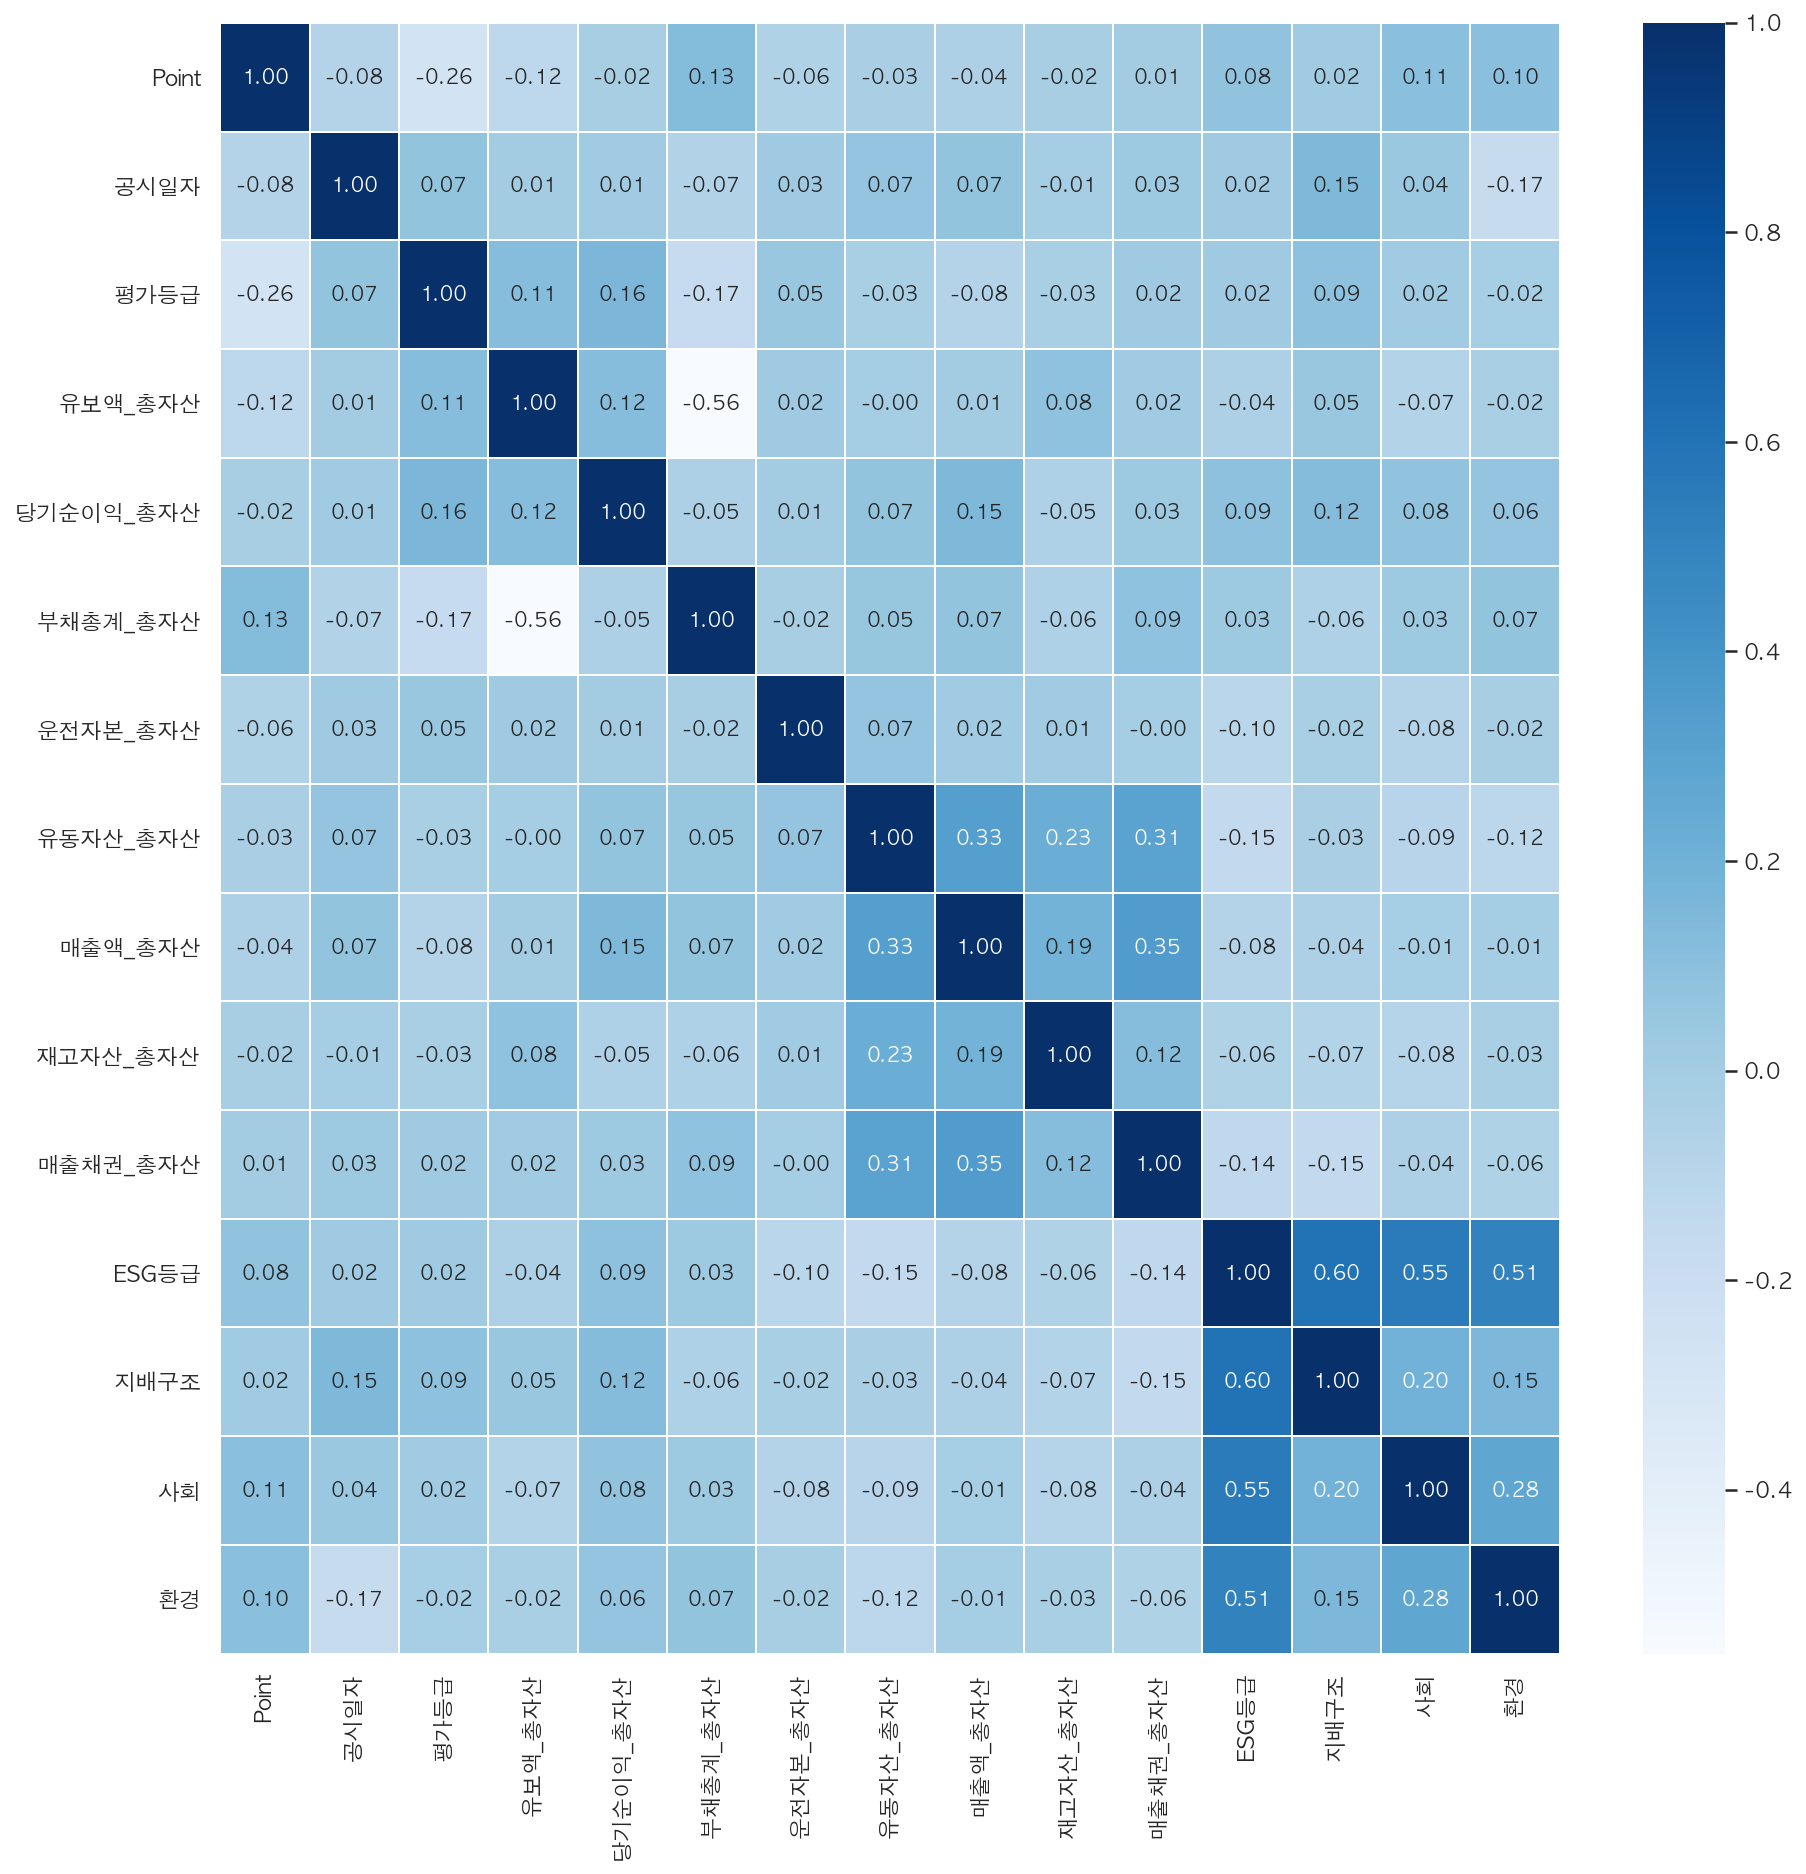

In [89]:
plt.figure(figsize=(15,15))
sns.heatmap(data = df_sum_2015_2020.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

In [90]:
# sns.pairplot(df_sum_2015_2020)
# plt.show()

In [98]:
df_x = df_sum_2015_2020.iloc[:,5:]
df_y = df_sum_2015_2020.iloc[:,1]

In [99]:
robust_scaler = RobustScaler()
rb = robust_scaler.fit(df_x)
output = robust_scaler.transform(df_x)
output = pd.DataFrame(output, columns=df_x.columns, index=list(df_x.index.values))
output["Y"] = df_y

In [100]:
from sklearn.linear_model import LinearRegression
model = sm.OLS.from_formula("Y ~유보액_총자산+매출채권_총자산+당기순이익_총자산+부채총계_총자산+운전자본_총자산+유동자산_총자산+매출액_총자산+재고자산_총자산+지배구조+사회+환경+0", data=output)
result = model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                      Y   R-squared (uncentered):                   0.078
Model:                            OLS   Adj. R-squared (uncentered):              0.054
Method:                 Least Squares   F-statistic:                              3.268
Date:                Fri, 26 Jun 2020   Prob (F-statistic):                    0.000260
Time:                        20:52:17   Log-Likelihood:                         -223.08
No. Observations:                 438   AIC:                                      468.2
Df Residuals:                     427   BIC:                                      513.1
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(result, fig=fig)

In [97]:
model = sm.Logit.from_formula("Y ~유보액_총자산+매출채권_총자산+당기순이익_총자산+부채총계_총자산+운전자본_총자산+유동자산_총자산+매출액_총자산+재고자산_총자산+지배구조+사회+환경+0", data=output)
result1 = model.fit()
print(result1.summary())

Optimization terminated successfully.
         Current function value: 0.675059
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      Y   No. Observations:                  438
Model:                          Logit   Df Residuals:                      427
Method:                           MLE   Df Model:                           10
Date:                Fri, 26 Jun 2020   Pseudo R-squ.:                 -0.4519
Time:                        20:51:39   Log-Likelihood:                -295.68
converged:                       True   LL-Null:                       -203.65
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
유보액_총자산       -0.1512      0.071     -2.139      0.032      -0.290      -0.013
매출채권_총자산       0.0041      0.

In [ ]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(result1, fig=fig)

## DecisionTreeClass

###  ESG통합 +E + S + G

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y,test_size=0.3)

In [ ]:
rb = robust_scaler.fit(X_train)
X_train = robust_scaler.transform(X_train)
X_test = robust_scaler.transform(X_test)

In [ ]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

In [ ]:
y_pred = list(model.predict(X_test))
y_true = list(np.array(y_test))

In [ ]:
print(model.predict(X_test).shape)
print(y_test.shape)

In [ ]:
print(len(y_test[y_test==1].dropna()))

In [ ]:
precision_score(y_true, y_pred, average='weighted')

In [ ]:
confusion_matrix(y_true, y_pred, labels=[1,0])

### 사회

In [ ]:
df_x2 = df_x.drop(columns =["ESG등급","지배구조","환경"])
X_train, X_test, y_train, y_test = train_test_split(df_x2, df_y,test_size=0.3)
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
print(len(y_test[y_test==1].dropna()))
y_pred = list(model.predict(X_test))
y_true = list(np.array(y_test))

In [ ]:
precision_score(y_true, y_pred, average='weighted')

In [ ]:
confusion_matrix(y_true, y_pred, labels=[1,0])

In [ ]:
df_x2 = df_x.drop(columns =["ESG등급","지배구조","환경"])
X_train, X_test, y_train, y_test = train_test_split(df_x2, df_y,test_size=0.3)
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
print(len(y_test[y_test==1].dropna()))
y_pred = list(model.predict(X_test))
y_true = list(np.array(y_test))

### ESG 전체 제거

In [ ]:
df_x5 = df_x.drop(columns =["ESG등급","지배구조","환경","사회"])
X_train, X_test, y_train, y_test = train_test_split(df_x5, df_y,test_size=0.3)
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = list(model.predict(X_test))
y_true = list(np.array(y_test))
print(len(y_test[y_test==1].dropna()))

In [ ]:
precision_score(y_true, y_pred, average='weighted')

In [ ]:
confusion_matrix(y_true, y_pred, labels=[1,0])